# Clustering Algorithm for Pairs Identification

In [1]:
import os
import pandas as pd
import random
import numpy as np
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
from matplotlib import pyplot as plt
%matplotlib inline

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

SEED = 8
random.seed(SEED)
np.random.seed(SEED)

### Inspect package versions & important package installation before running DTW

## <font color='red'> Important to note DTWParallel package is not compatible with Python 3.10, please use version 3.9 or at least 3.6.1 <font>

In [2]:
# DTW algorithm requires Python version to be atleast 3.6.1 up to version 3.9
from platform import python_version
import sklearn

print(sklearn.show_versions()
     )
print(python_version()
     )
print(pd.__version__)


System:
    python: 3.9.15 (main, Nov 24 2022, 14:39:17) [MSC v.1916 64 bit (AMD64)]
executable: C:\Users\stan_\anaconda3\python.exe
   machine: Windows-10-10.0.22621-SP0

Python dependencies:
          pip: 23.1.2
   setuptools: 65.5.0
      sklearn: 1.0.2
        numpy: 1.21.4
        scipy: 1.8.0
       Cython: 0.29.32
       pandas: 2.0.2
   matplotlib: 3.5.3
       joblib: 1.1.1
threadpoolctl: 3.1.0

Built with OpenMP: True
None
3.9.15
2.0.2


C:\Users\stan_\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [3]:
!python --version

Python 3.9.15


In [4]:
import numba
numba.__version__

'0.56.3'

In [5]:
#!pip install dtwParallel
#!pip install setuptools
#!pip install gower
#!pip install numba
#!pip install pandas==1.5.3

### Load ML Packages

In [6]:
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
# k modes(find mode), K Medroids(find median)

from scipy.cluster.hierarchy import fcluster # for hierachicial clustering

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet #for hierachicial clustering

from scipy.spatial.distance import pdist

from sklearn.metrics import adjusted_mutual_info_score

from sklearn import cluster, covariance, manifold

import matplotlib.ticker as ticker
from itertools import cycle

In [7]:
# from google.colab import drive

In [8]:
#   drive.mount('/content/drive')

# Load Data and Data Wrangle

In [9]:
df = pd.read_csv("hkex_stocks_top100pv.csv")
# Convert "Date" to date time format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df

,Date,Ticker,Name,Nominal Price,Bid,Ask,High,Low,Share Volume (000),Turnover (000)
0,2014-02-04,700,TENCENT,102.099998,NaN,NaN,107.099998,101.800003,48705345.0,NaN
1,2014-02-05,700,TENCENT,102.099998,NaN,NaN,104.800003,100.500000,34070720.0,NaN
2,2014-02-06,700,TENCENT,101.699997,NaN,NaN,103.099998,100.000000,29635165.0,NaN
3,2014-02-07,700,TENCENT,104.900002,NaN,NaN,106.099998,101.699997,34092130.0,NaN
4,2014-02-10,700,TENCENT,106.699997,NaN,NaN,107.300003,105.199997,32769650.0,NaN
...,...,...,...,...,...,...,...,...,...,...
179972,2023-05-16,914,CONCH CEMENT,23.550000,23.55,23.60,24.350000,23.350000,7935.0,187462.0
179973,2023-05-17,914,CONCH CEMENT,23.000000,22.95,23.00,23.600000,22.800000,8430.0,195121.0
179974,2023-05-18,914,CONCH CEMENT,22.850000,22.80,22.85,23.150000,22.700000,6600.0,150929.0
179975,2023-05-19,914,CONCH CEMENT,22.400000,22.35,22.40,22.800000,22.100000,8385.0,187725.0


In [10]:
df = df.iloc[:,:4]

In [11]:
df.isna().any()

Date             False
Ticker           False
Name             False
Nominal Price    False
dtype: bool

In [12]:
df.dtypes

Date             datetime64[ns]
Ticker                    int64
Name                     object
Nominal Price           float64
dtype: object

In [13]:
df['Ticker'] = df['Ticker'].astype('object')

## Pivot Dataset and Data Processing

In [14]:
df_new = df.pivot_table(index='Date', columns='Ticker', values='Nominal Price')

In [15]:
df_new

Ticker,1,5,6,16,20,27,123,168,175,241,...,9633,9696,9868,9888,9926,9959,9961,9966,9988,9999
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-16,51.50,59.70,46.65,105.7,2.22,52.00,9.38,75.80,9.73,5.08,...,42.05,60.10,37.85,124.3,42.20,2.54,264.0,13.84,85.75,139.5
2023-05-17,51.05,58.65,46.45,103.8,2.17,51.05,9.13,73.30,9.47,4.87,...,41.55,57.95,36.50,123.8,37.65,2.49,259.2,13.20,85.45,136.2
2023-05-18,51.05,59.45,46.25,103.0,2.24,51.90,9.14,73.10,9.46,4.79,...,41.50,59.10,36.25,125.6,37.00,2.60,269.6,10.82,87.75,139.4


# Define Clustering Set

In [16]:
# Clustering set from '2014-02-04' to '2018-05-21'
df_new = df_new.loc[:"2018-05-21"]

In [17]:
# Missing values
df_new.isnull().sum().sum()

33971

#### Remove columns with > 30% of the values missing

In [18]:
missing_fractions = \
    df_new \
    .isnull() \
    .mean() \
    .sort_values(ascending = False)

In [19]:
missing_fractions.head(10)

Ticker
1725    1.0
6690    1.0
1772    1.0
1797    1.0
1801    1.0
1810    1.0
2013    1.0
2015    1.0
2367    1.0
3690    1.0
dtype: float64

In [20]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index)
                  )

print(f"The total number of tickers with > 30% missing values {len(drop_list)}")

The total number of tickers with > 30% missing values 32


In [21]:
df_new.drop(labels= drop_list,
             axis=1,
             inplace = True)

C:\Users\stan_\AppData\Local\Temp\ipykernel_20908\75797323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new.drop(labels= drop_list,


In [22]:
df_new.shape

(1057, 68)

In [23]:
# Fill the missing values with the last value available in the dataset.

dataset = df_new.fillna(method = "bfill")
dataset

Ticker,1,5,6,16,20,27,123,168,175,241,...,2601,2628,2688,2899,3800,3888,3900,3968,3988,6030
Date,,,,,,,,,,,,,,,,,,,,,
2014-02-04,118.40,84.35,62.75,99.3,32.45,72.70,1.63,57.95,3.01,4.24,...,27.30,22.85,52.85,1.73,2.80,26.35,11.66,14.12,3.25,16.34
2014-02-05,118.40,84.35,62.75,99.3,32.45,72.70,1.63,57.95,3.01,4.24,...,27.30,22.85,52.85,1.73,2.80,26.35,11.66,14.12,3.25,16.34
2014-02-06,118.40,84.35,62.75,99.3,32.45,72.70,1.63,57.95,3.01,4.24,...,27.30,22.85,52.85,1.73,2.80,26.35,11.66,14.12,3.25,16.34
2014-02-07,118.40,84.35,62.75,99.3,32.45,72.70,1.63,57.95,3.01,4.24,...,27.30,22.85,52.85,1.73,2.80,26.35,11.66,14.12,3.25,16.34
2014-02-10,118.40,84.35,62.75,99.3,32.45,72.70,1.63,57.95,3.01,4.24,...,27.30,22.85,52.85,1.73,2.80,26.35,11.66,14.12,3.25,16.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-15,90.00,77.95,55.90,129.0,59.05,68.25,1.81,47.95,23.20,4.34,...,36.40,22.55,75.00,3.59,0.95,24.40,12.08,34.95,4.25,19.70
2018-05-16,89.75,78.05,55.35,128.2,59.35,67.15,1.81,48.60,23.20,4.44,...,36.35,22.60,74.40,3.57,0.95,23.95,11.96,34.60,4.25,19.88
2018-05-17,89.05,77.00,54.50,127.4,58.60,67.05,1.78,47.95,23.05,5.60,...,35.65,22.40,76.75,3.52,0.95,23.45,11.84,33.85,4.20,19.52


#### Dataset universe has been reduced to `68` stocks from the original `100` after removing tockers with >30% missing values

### Data Transformation

> For the purpose of clustering we will convert data into `monthly` percentage returns to represent indicators of stock performance

In [24]:
#Calculate average monthly percentage returns

returns = dataset.pct_change() * 21
returns = pd.DataFrame(returns).dropna().transpose()
returns.head()
# returns.columns = ["Returns"]

Date,2014-02-05,2014-02-06,2014-02-07,2014-02-10,2014-02-11,2014-02-12,2014-02-13,2014-02-14,2014-02-17,2014-02-18,...,2018-05-08,2018-05-09,2018-05-10,2018-05-11,2018-05-14,2018-05-15,2018-05-16,2018-05-17,2018-05-18,2018-05-21
Ticker,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.150082,0.045852,-0.034314,0.160393,0.193286,-0.721030,-0.058333,-0.163788,-0.070747,0.011831
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.223702,0.055336,0.275953,0.122568,0.230174,-0.120536,0.026940,-0.282511,0.068182,0.149515
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.090206,0.269461,-0.124155,0.178420,-0.937658,-0.296296,-0.206619,-0.322493,0.077064,0.191956
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.376221,-0.016800,0.117694,0.234076,0.396850,-0.064915,-0.130233,-0.131045,0.000000,0.148352
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.169355,-0.093333,0.000000,0.337500,0.738137,0.053480,0.106689,-0.265375,0.161263,0.177815


In [25]:
data = returns

In [26]:
data.isna().any().sum()

0

### Data Standardization For ML - `Clustering`

> It is important to standardize the data prior to performing any machine learning model to avoid larger values from dominating smaller values in the dataset

> Use `StandardScaler` in sklearn to standardize dataset into N~(Mean=0, Variance=1) using the formula $Z=\frac{x - \mu}{\sigma}$

In [27]:
from sklearn.preprocessing import StandardScaler
from scipy.stats.mstats import winsorize

scaler = StandardScaler().fit(data)

rescaledDataset = pd.DataFrame(scaler.fit_transform(data),columns = data.columns, index = data.index)
rescaledDataset.head()

C:\Users\stan_\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\stan_\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\stan_\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(


Date,2014-02-05,2014-02-06,2014-02-07,2014-02-10,2014-02-11,2014-02-12,2014-02-13,2014-02-14,2014-02-17,2014-02-18,...,2018-05-08,2018-05-09,2018-05-10,2018-05-11,2018-05-14,2018-05-15,2018-05-16,2018-05-17,2018-05-18,2018-05-21
Ticker,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.122169,-0.122169,-0.122169,0.122169,-0.122169,-0.122169,-0.122169,-0.122169,-0.122169,...,-0.421489,-0.093757,-0.423120,0.190012,-0.305457,-1.509626,-0.270399,-0.132373,-0.564430,-0.138727
5,0.0,0.122169,-0.122169,-0.122169,0.122169,-0.122169,-0.122169,-0.122169,-0.122169,-0.122169,...,-0.233706,-0.064139,0.606029,0.052624,-0.210603,-0.033244,0.054794,-0.285257,-0.195861,0.263816
6,0.0,0.122169,-0.122169,-0.122169,0.122169,-0.122169,-0.122169,-0.122169,-0.122169,-0.122169,...,-0.574216,0.604534,-0.721123,0.255490,-3.213609,-0.465371,-0.835889,-0.336743,-0.172296,0.387902
16,0.0,0.122169,-0.122169,-0.122169,0.122169,-0.122169,-0.122169,-0.122169,-0.122169,-0.122169,...,0.155329,-0.289406,0.081088,0.457649,0.217995,0.103506,-0.544588,-0.090208,-0.376743,0.260416
20,0.0,0.122169,-0.122169,-0.122169,0.122169,-0.122169,-0.122169,-0.122169,-0.122169,-0.122169,...,-0.372330,-0.528405,-0.309302,0.833308,1.095592,0.394594,0.358918,-0.263190,0.051077,0.346559


In [28]:
# summarize transformed data
X = rescaledDataset

In [29]:
print(np.isinf(X.sum().sum()))
print(X.isna().sum().sum())

False
0


### Data Windsorization
> Winsorization is the process of replacing the extreme values of dataset in order to limit the effect of the outliers in the data. The mean value calculated after such replacement of the extreme values is called winsorized mean.

> Here we windsorize 90% of the dataset mean by replacing top 5% and bottom 5% of the outliers with datapoints at the 95th percentile and 5th percentile of the dataset.

> We've decided to Winsorize our dataset to 90% of the mean. This decision aims to mitigate the K-Means algorithm's sensitivity to outliers, unlike Hierarchical Clustering and Affinity Propagation, which handle outliers better. This step ensures a fair comparison of the clustering techniques' performance metrics.

Date
2014-02-05    0.000000e+00
2014-02-06   -4.816409e-17
2014-02-07   -4.081702e-19
2014-02-10   -1.240837e-16
2014-02-11   -4.081702e-19
                  ...     
2018-05-15    2.612289e-17
2018-05-16   -4.081702e-17
2018-05-17   -1.551047e-17
2018-05-18    2.000034e-16
2018-05-21    7.102162e-17
Length: 1056, dtype: float64


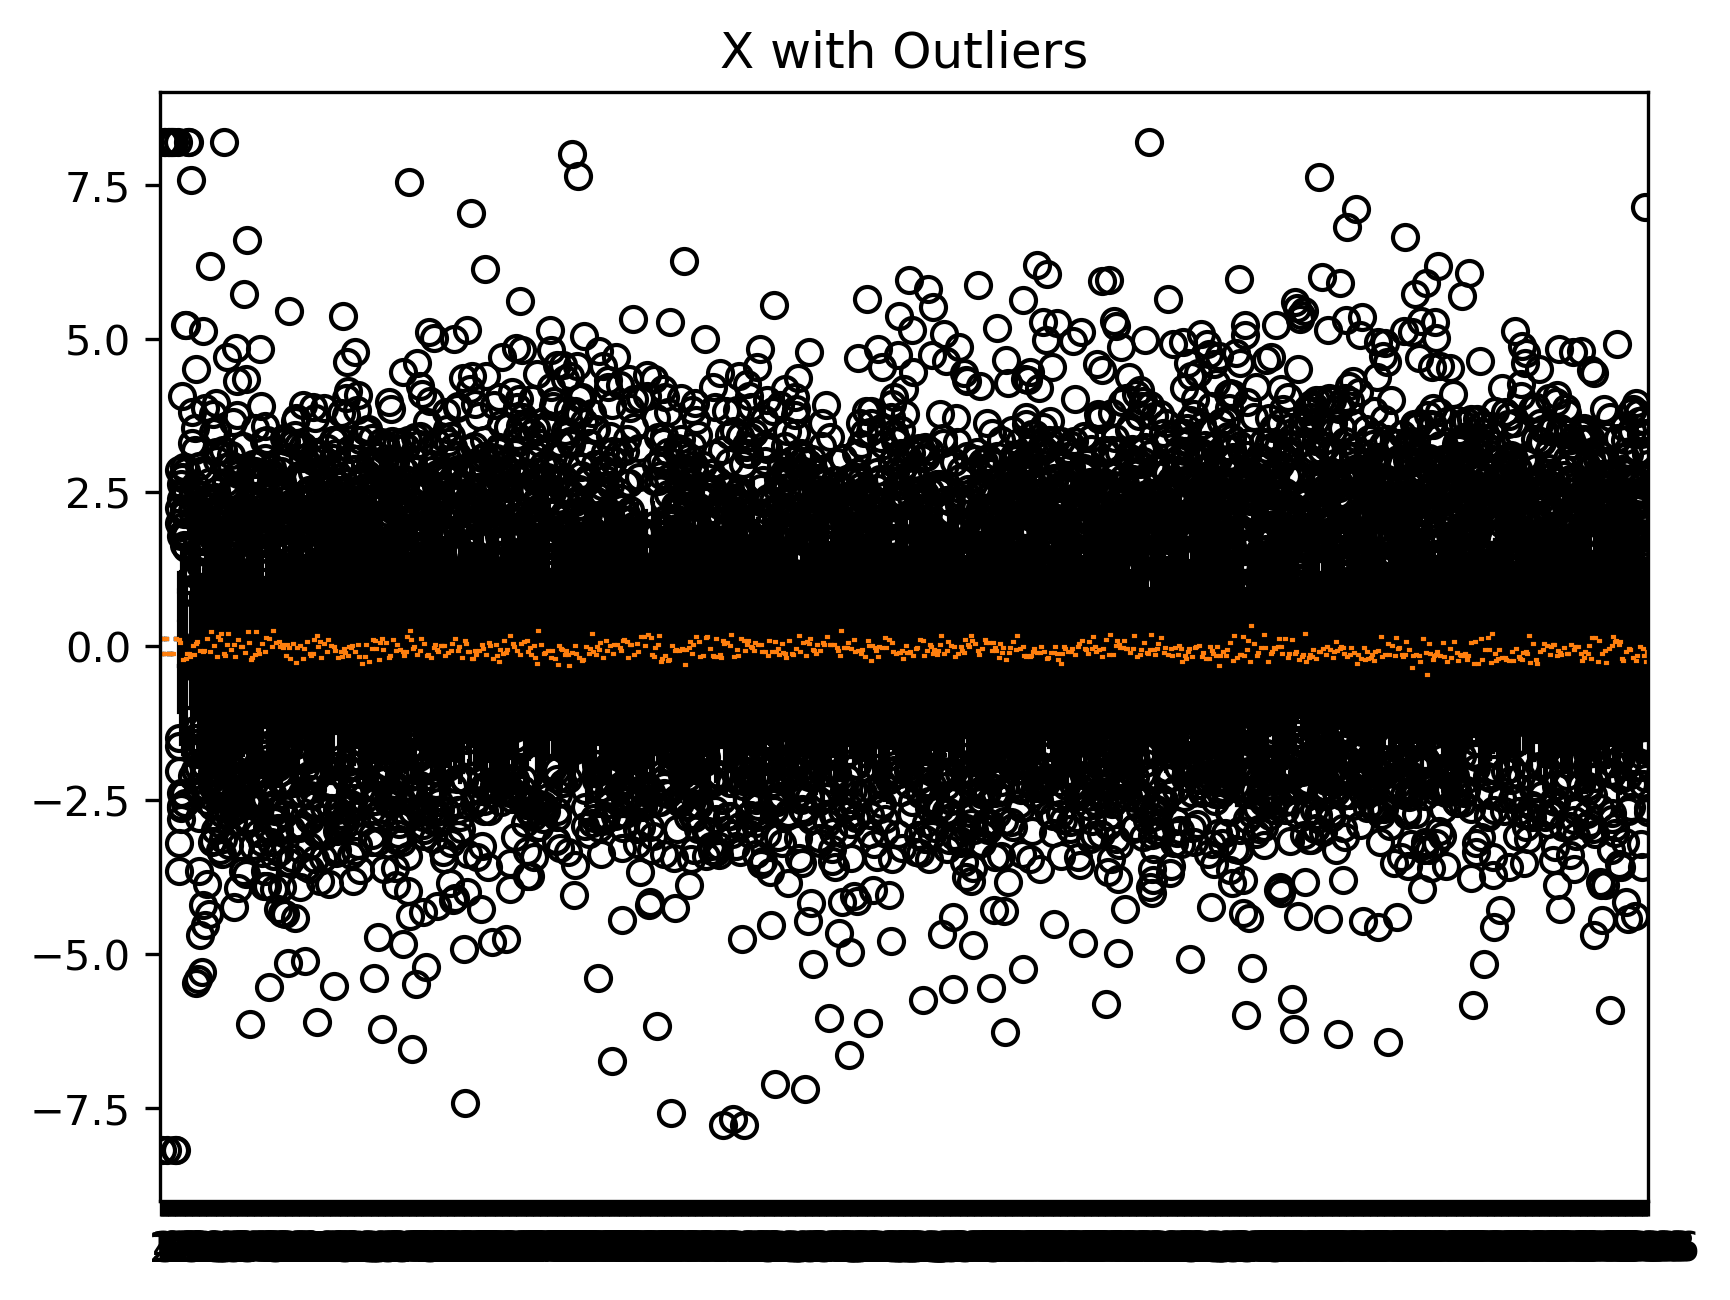

In [30]:
plt.boxplot(X)
plt.title("X with Outliers")
print(X.mean())

In [31]:
X = X.apply(lambda x: winsorize(x, limits=(0.05,0.05)))

Date
2014-02-05    0.000000
2014-02-06    0.122169
2014-02-07   -0.122169
2014-02-10   -0.122169
2014-02-11    0.122169
                ...   
2018-05-15    0.031676
2018-05-16   -0.033829
2018-05-17   -0.091785
2018-05-18   -0.042789
2018-05-21    0.005512
Length: 1056, dtype: float64


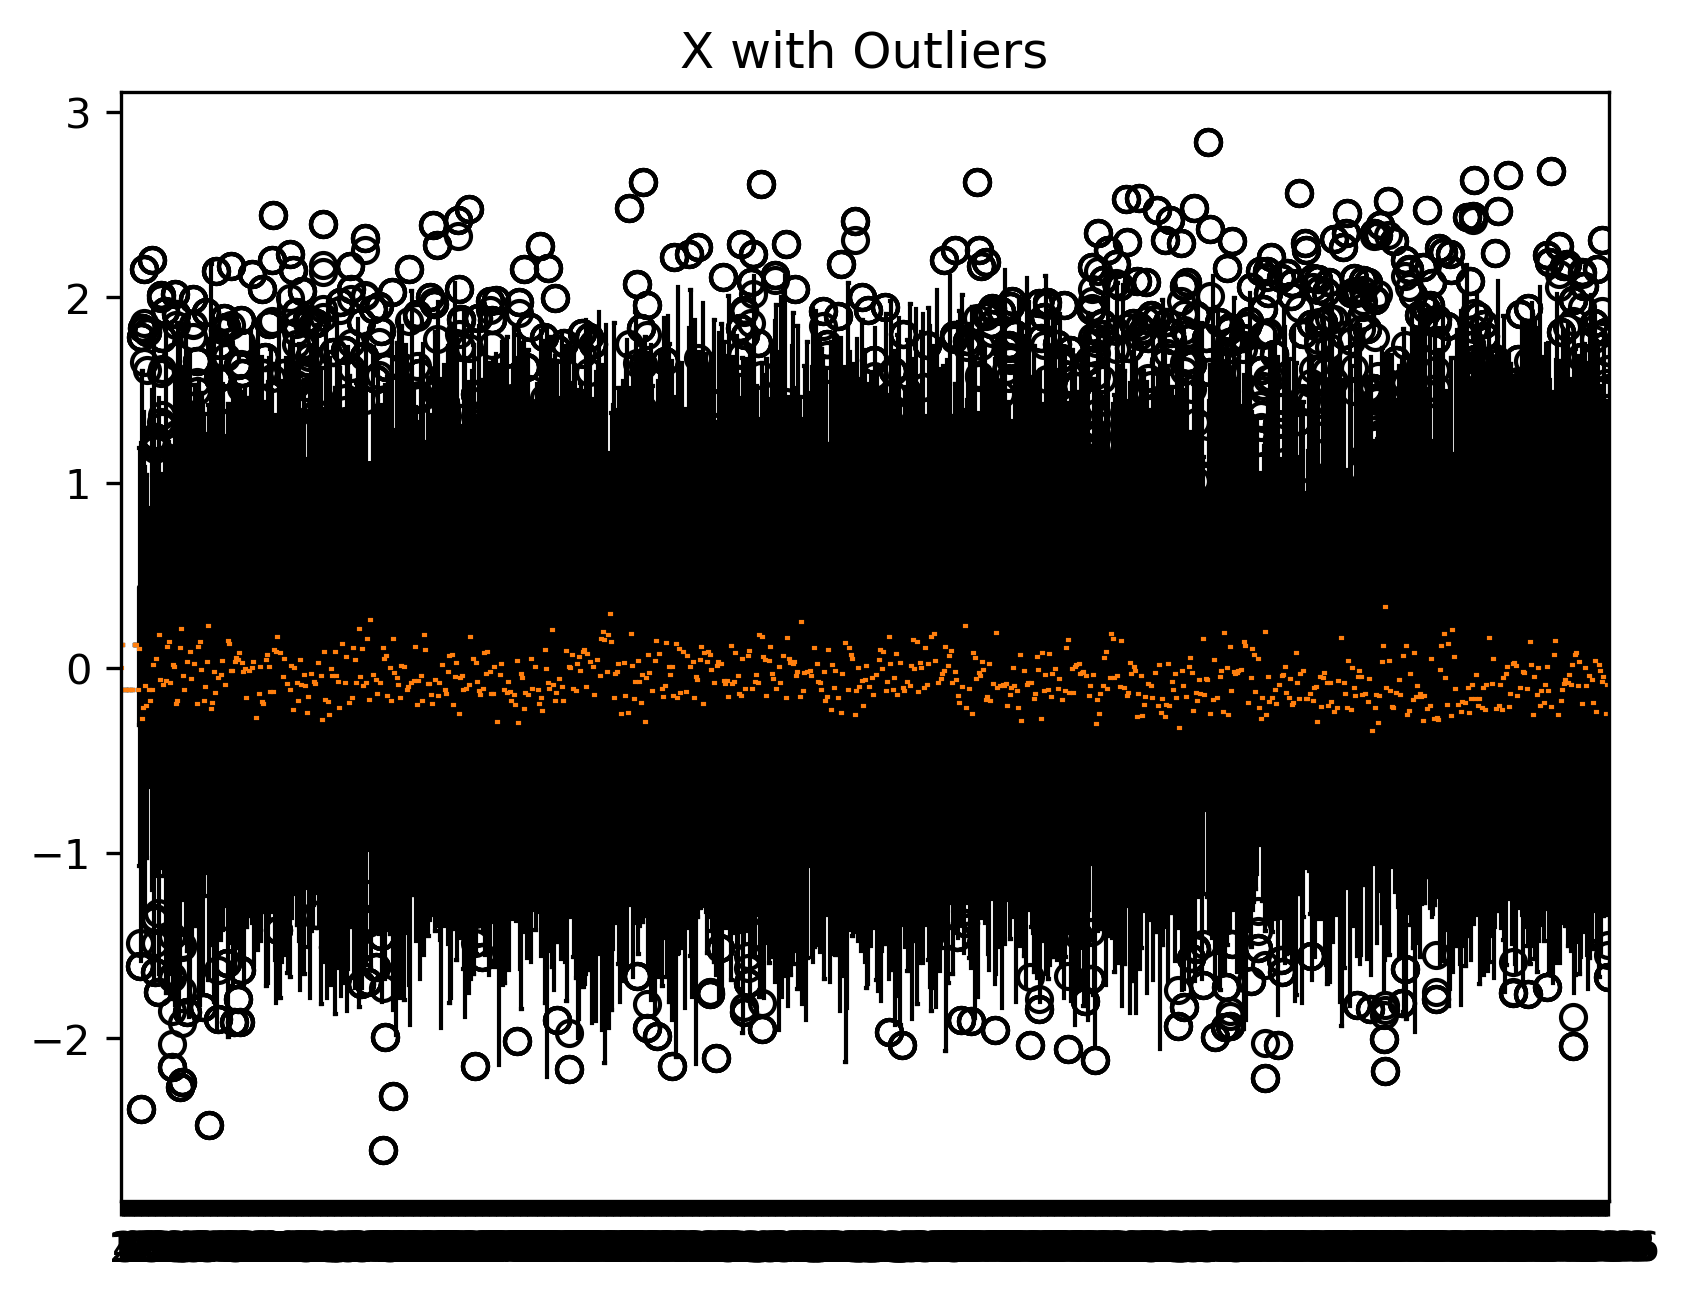

In [32]:
plt.boxplot(X)
plt.title("X with Outliers")
print(X.mean())

## Dynamic Time Warping
##### For DTW package we are using dtwParallelpacakge as published in peer reviewed journal:
> #### Reference:
_Escudero Arnanz, O., G Marques, A., Soguero-Ruiz, C., Mora-Jiménez, I., & Robles, G.(2023) Dtwparallel: A Python Package to Efficiently Compute Dynamic Time Warping. Original Software Publication, Software X. Volume 22, 101364. https://doi.org/10.1016/j.softx.2023.101364_

> Before running DTW package recommend to update Python versions to `3.6.1` and relevant packages below to run objective function computations

* numpy
* pandas
* matplotlib
* seaborn
* gower
* setuptools
* scipy
* joblib
* numba

> Dynamic Time Warping is adept at managing time series sequences of varying lengths, time series distortion and warping. Unlike Euclidean distance methods, DTW warps the time aspect of sequences to enhance alignment, which enables comparisons of sequences that may be similar yet out of phase or different in lengths. This unique ability allows DTW to manage intricate distance sequences more effectively compared to the Euclidean distance measure, which solely relies on linear calculations.

#### DTW calculation made use of distance optimzation technique that is built on minimizing "Manhattan distance" measure as exemplifies also by Nakagawa et. al (2019)


#### To minimize warping computational cost, we applied commonly known global constraints. "Sakoe Chiba Band" global constraint is applied due to its lower error rate and higher accuracy in DTW distance mapping than "Itakura Parallelogram" as explained by Geler et. at. (2022)

> #### Reference:

_Nakagawa, K., Imamura, M., & Yoshida, K. (2019). Stock price prediction using k‐medoids clustering with indexing dynamic time warping. Electronics and Communications in Japan, 102(2), 3-8._

_Geler, Z., Kurbalija, V., Ivanović, M., & Radovanović, M. (2022). Elastic distances for time-series classification: Itakura versus Sakoe-Chiba constraints. Knowledge and Information Systems, 64(10), 2797-2832._

In [33]:
from dtwParallel import dtw_functions as dtw
from scipy.spatial import distance as distance
import warnings
warnings.filterwarnings('ignore')

def calculate_dtw1(df):
    # Create an empty DataFrame to store the results
    results1 = pd.DataFrame(columns=['Ticker_1', 'Ticker_2', 'DTW_Distance'])

    # Iterate over each ticker in the DataFrame
    for i in range(len(df)):
        Ticker_1 = df.index[i]
        x = np.asarray([df.loc[Ticker_1]])

        # Compare the current ticker with all other tickers
        for j in range(i + 1, len(df)):
            Ticker_2 = df.index[j]
            y = np.asarray([df.loc[Ticker_2]])

            # Calculate the DTW distance
            dtw_distance = dtw.dtw(x, y,
                                   type_dtw="d",
                                   constrained_path_search="sakoe_chiba",
                                   local_dissimilarity=distance.cityblock,
                                   check_errors=True,
                                   MTS=True)

            # Add the result to the DataFrame
            new_row = pd.DataFrame({
                'Ticker_1': [Ticker_1],
                'Ticker_2': [Ticker_2],
                'DTW_Distance': [dtw_distance]
            })

            results1 = pd.concat([results1, new_row], ignore_index=True)

    # Return the results
    return results1

In [34]:
results1 = calculate_dtw1(X)

In [35]:
results1

,Ticker_1,Ticker_2,DTW_Distance
0,1,5,546.694290
1,1,6,542.502692
2,1,16,539.733590
3,1,20,687.982431
4,1,27,919.943987
...,...,...,...
2273,3900,3988,950.109399
2274,3900,6030,984.154705
2275,3968,3988,569.318047
2276,3968,6030,780.577866


In [36]:
results1 = results1.sort_values('DTW_Distance')
results1.reset_index(drop=True, inplace=True)
results1.to_csv('V2_dtw_matrix-HK100-_pre-cluster.csv')

In [37]:
X = results1

In [38]:
X

,Ticker_1,Ticker_2,DTW_Distance
0,939,1398,317.598934
1,939,3988,337.666460
2,1398,3988,342.060501
3,1288,3988,367.818565
4,939,1288,369.572016
...,...,...,...
2273,2007,2382,1289.715702
2274,1177,2382,1292.400484
2275,2382,3800,1292.481747
2276,2382,3900,1295.989470


In [39]:
X.isna().sum()

Ticker_1        0
Ticker_2        0
DTW_Distance    0
dtype: int64

In [40]:
# Calculate the average DTW distance for each stock
average_distances = pd.concat([X.groupby('Ticker_1')['DTW_Distance'].mean(), X.groupby('Ticker_2')['DTW_Distance'].mean()]).groupby(level=0).mean()

# Reshape the data for KMeans
X_reshaped = pd.DataFrame(average_distances, columns=['Average_DTW_Distance'])
# Fill missing values with the overall mean DTW distance
X_reshaped = X_reshaped.fillna(X_reshaped['Average_DTW_Distance'].mean())


# # Run KMeans
# k_means = cluster.KMeans(n_clusters=nclust)
# k_means.fit(X_reshaped)

# # Create the Series
# clustered_series_km = pd.Series(index=X_reshaped.index, data=k_means.labels_.flatten())
# clustered_series_km = clustered_series_km[clustered_series_km != -1]


In [41]:
unique_ticker_1 = X['Ticker_1'].unique()
unique_ticker_2 = X['Ticker_2'].unique()

common_tickers = set(unique_ticker_1) & set(unique_ticker_2)

print("Number of unique tickers in 'Ticker_1':", len(unique_ticker_1))
print("Number of unique tickers in 'Ticker_2':", len(unique_ticker_2))
print("Number of common tickers:", len(common_tickers))


Number of unique tickers in 'Ticker_1': 67
Number of unique tickers in 'Ticker_2': 67
Number of common tickers: 66


In [42]:
print(X.groupby('Ticker_1')['DTW_Distance'].mean())
print(X.groupby('Ticker_2')['DTW_Distance'].mean())


Ticker_1
1        816.076169
5        806.333038
6        856.575587
16       826.949543
20       924.627862
           ...     
3800    1090.658766
3888    1039.929209
3900     976.922585
3968     674.947957
3988     712.698500
Name: DTW_Distance, Length: 67, dtype: float64
Ticker_2
5        546.694290
6        562.931318
16       565.317028
20       695.495959
27       956.713072
           ...     
3888    1068.205444
3900    1082.149433
3968     886.092534
3988     773.890009
6030     926.030737
Name: DTW_Distance, Length: 67, dtype: float64


In [43]:
concatenated = pd.concat([X.groupby('Ticker_1')['DTW_Distance'].mean(), X.groupby('Ticker_2')['DTW_Distance'].mean()])
print(concatenated)
print(concatenated.groupby(level=0).mean())


1        816.076169
5        806.333038
6        856.575587
16       826.949543
20       924.627862
           ...     
3888    1068.205444
3900    1082.149433
3968     886.092534
3988     773.890009
6030     926.030737
Name: DTW_Distance, Length: 134, dtype: float64
1        816.076169
5        676.513664
6        709.753452
16       696.133285
20       810.061911
           ...     
3888    1054.067326
3900    1029.536009
3968     780.520245
3988     743.294255
6030     926.030737
Name: DTW_Distance, Length: 68, dtype: float64


In [44]:
X_reshaped = pd.DataFrame({'Average_DTW_Distance': concatenated})
print(X_reshaped.shape)
print(X_reshaped.head())


(134, 1)
    Average_DTW_Distance
1             816.076169
5             806.333038
6             856.575587
16            826.949543
20            924.627862


In [45]:
X_reshaped = X_reshaped.groupby(level=0).mean()
print(X_reshaped.shape)
print(X_reshaped.head())


(68, 1)
    Average_DTW_Distance
1             816.076169
5             676.513664
6             709.753452
16            696.133285
20            810.061911


In [46]:
X_reshaped

,Average_DTW_Distance
1,816.076169
5,676.513664
6,709.753452
16,696.133285
20,810.061911
...,...
3888,1054.067326
3900,1029.536009
3968,780.520245
3988,743.294255


## K-Means Clustering
> Using the "elbow method" to identify the optimal no. of clusters

> "Sum of Squared Distance between datapoints and cluster centroid (SSD) plotted against no. of clusters

> The "elbow" represents the point of diminishing returns (adding more clusters does not significantly decrease the SSE)

Text(0, 0.5, 'Inertia')

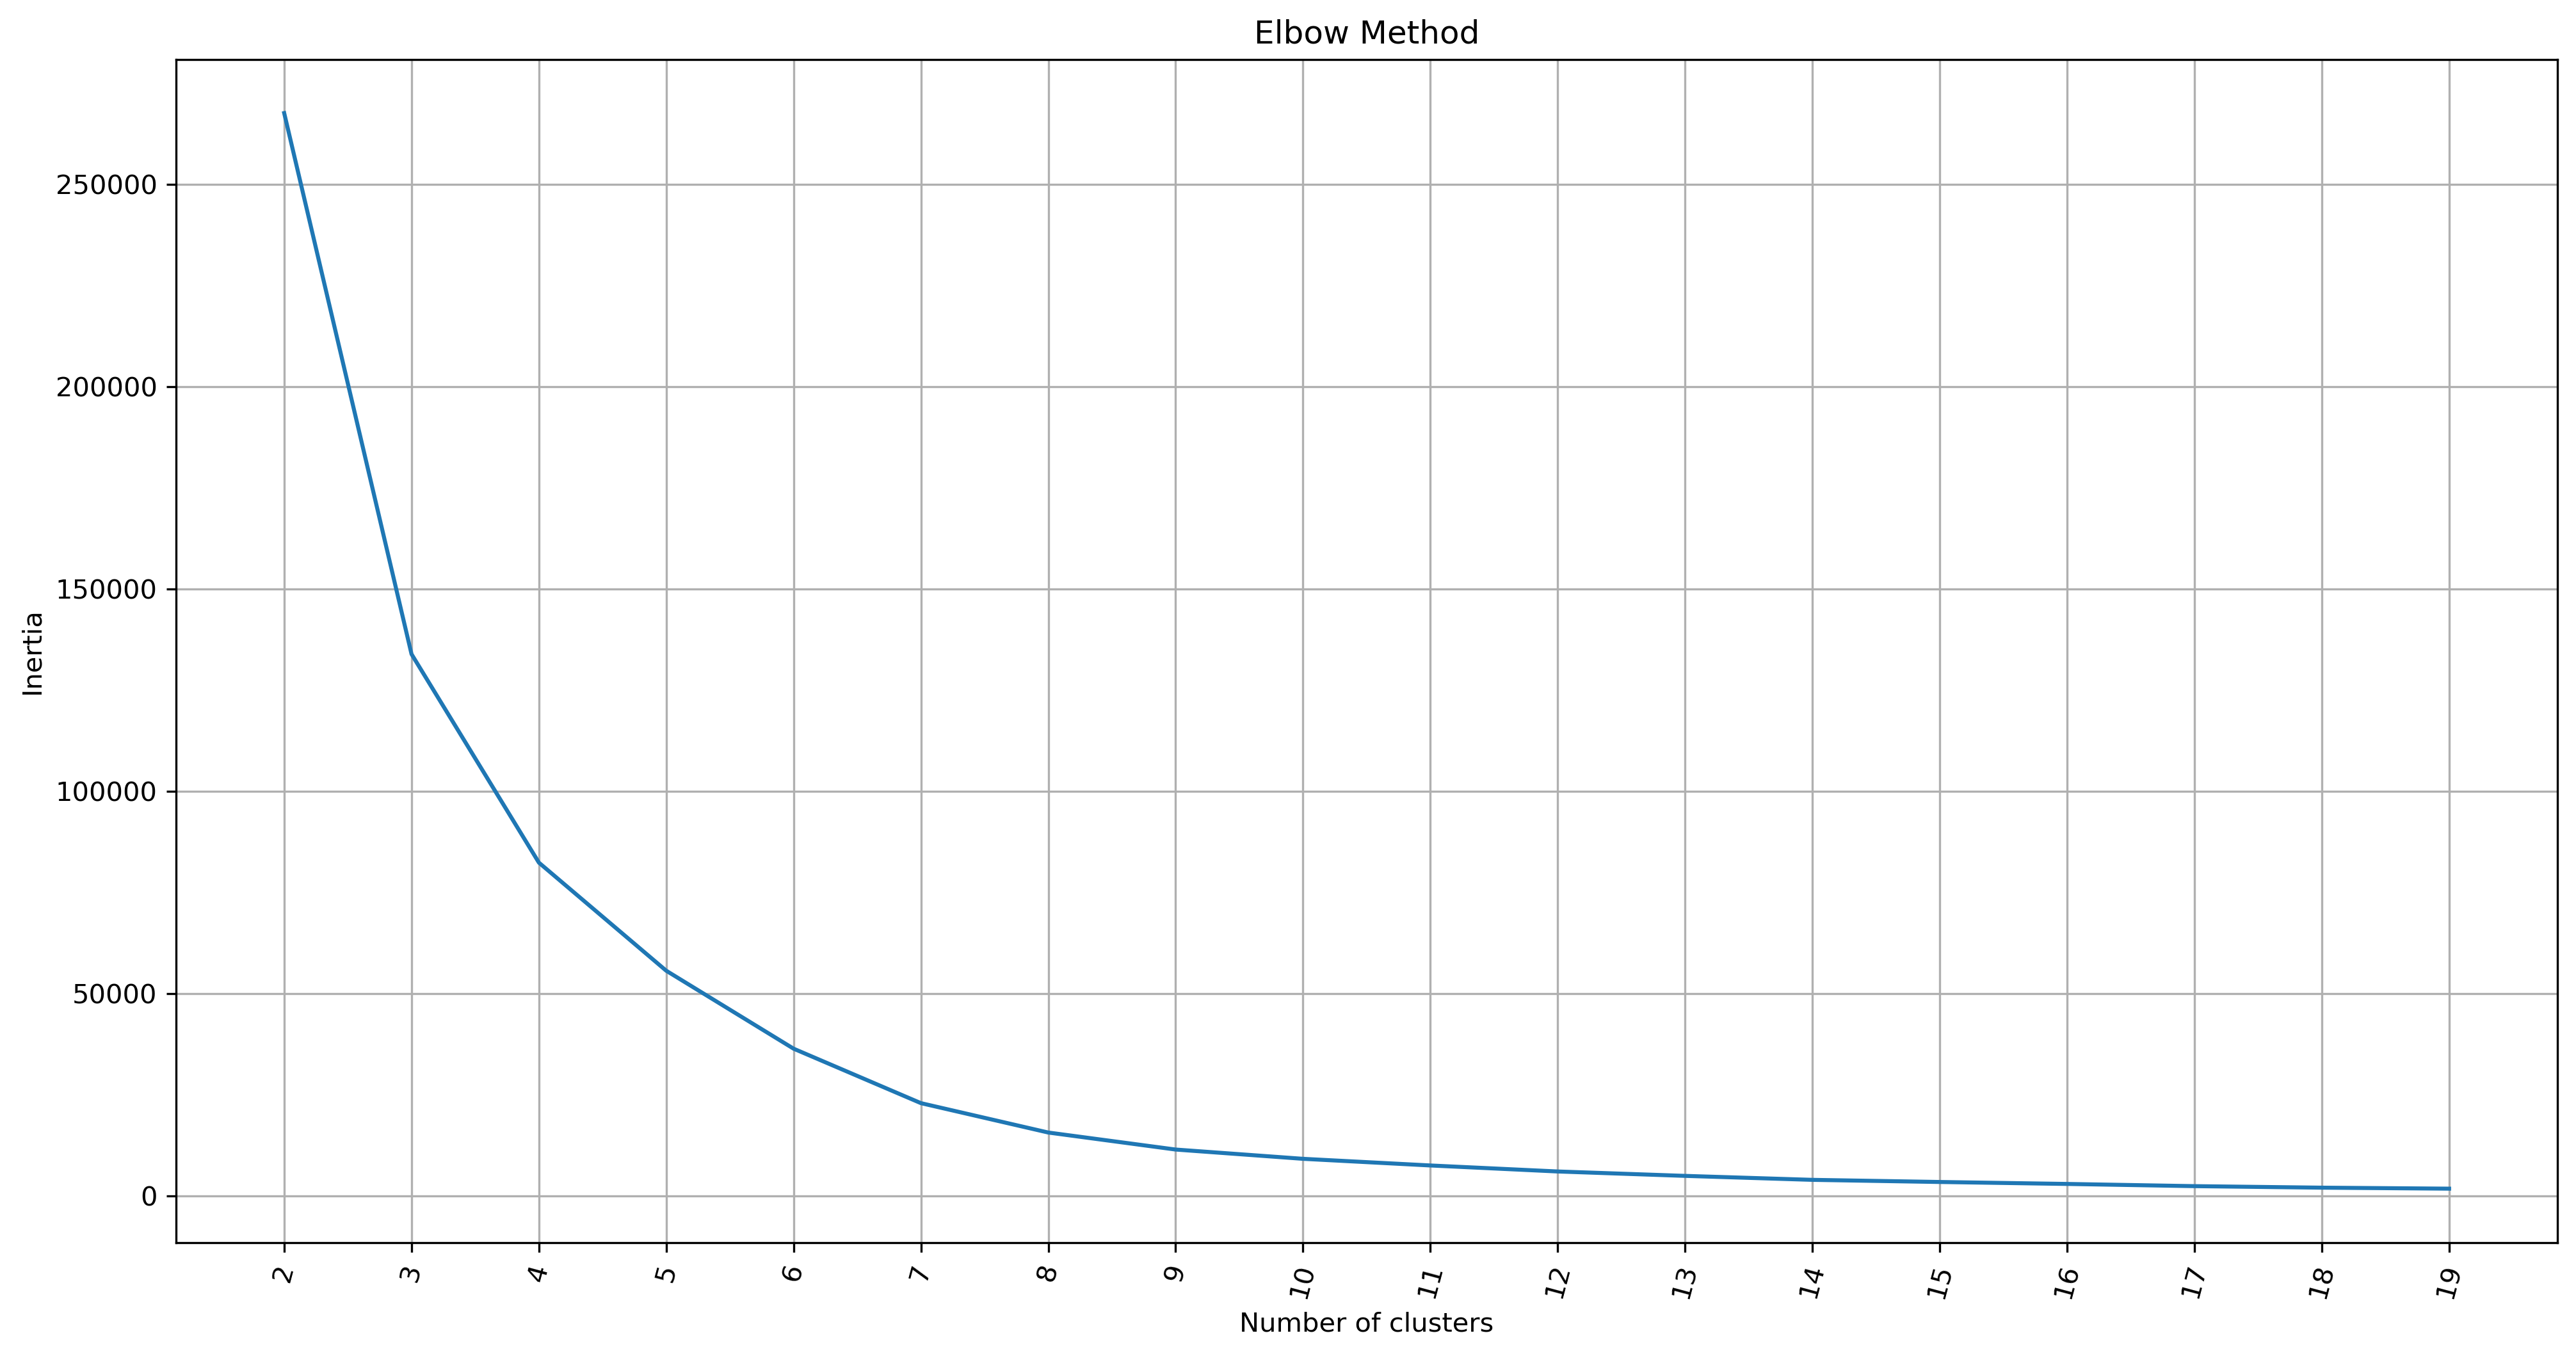

In [47]:
distorsions = []

max_loop = 20 #Max no. of k clusters set to 20 for the algorithm to consider

for k in range(2, max_loop): #range starting from k=2 because that is the minimum cluster requirement of K-Mean algorithm
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X_reshaped)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(16, 8))

plt.plot(range(2, max_loop), distorsions) #log(Sum of Squared Errors of each cluster) - Log(Weighted Sum of Sq of Errors of allclusters)

plt.xticks([i for i in range(2, max_loop)],
           rotation=75)

plt.grid(True)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

> Inferring from the SSD chart, we can identify about 3 or 4 clusters and increasing no. of clusters will not significantly decrease SSD

In [48]:
nclust = 4

# Fit with k-means
k_means = cluster.KMeans(n_clusters=nclust)
k_means.fit(X_reshaped)

KMeans(n_clusters=4)

In [49]:
target_labels = k_means.predict(X_reshaped)

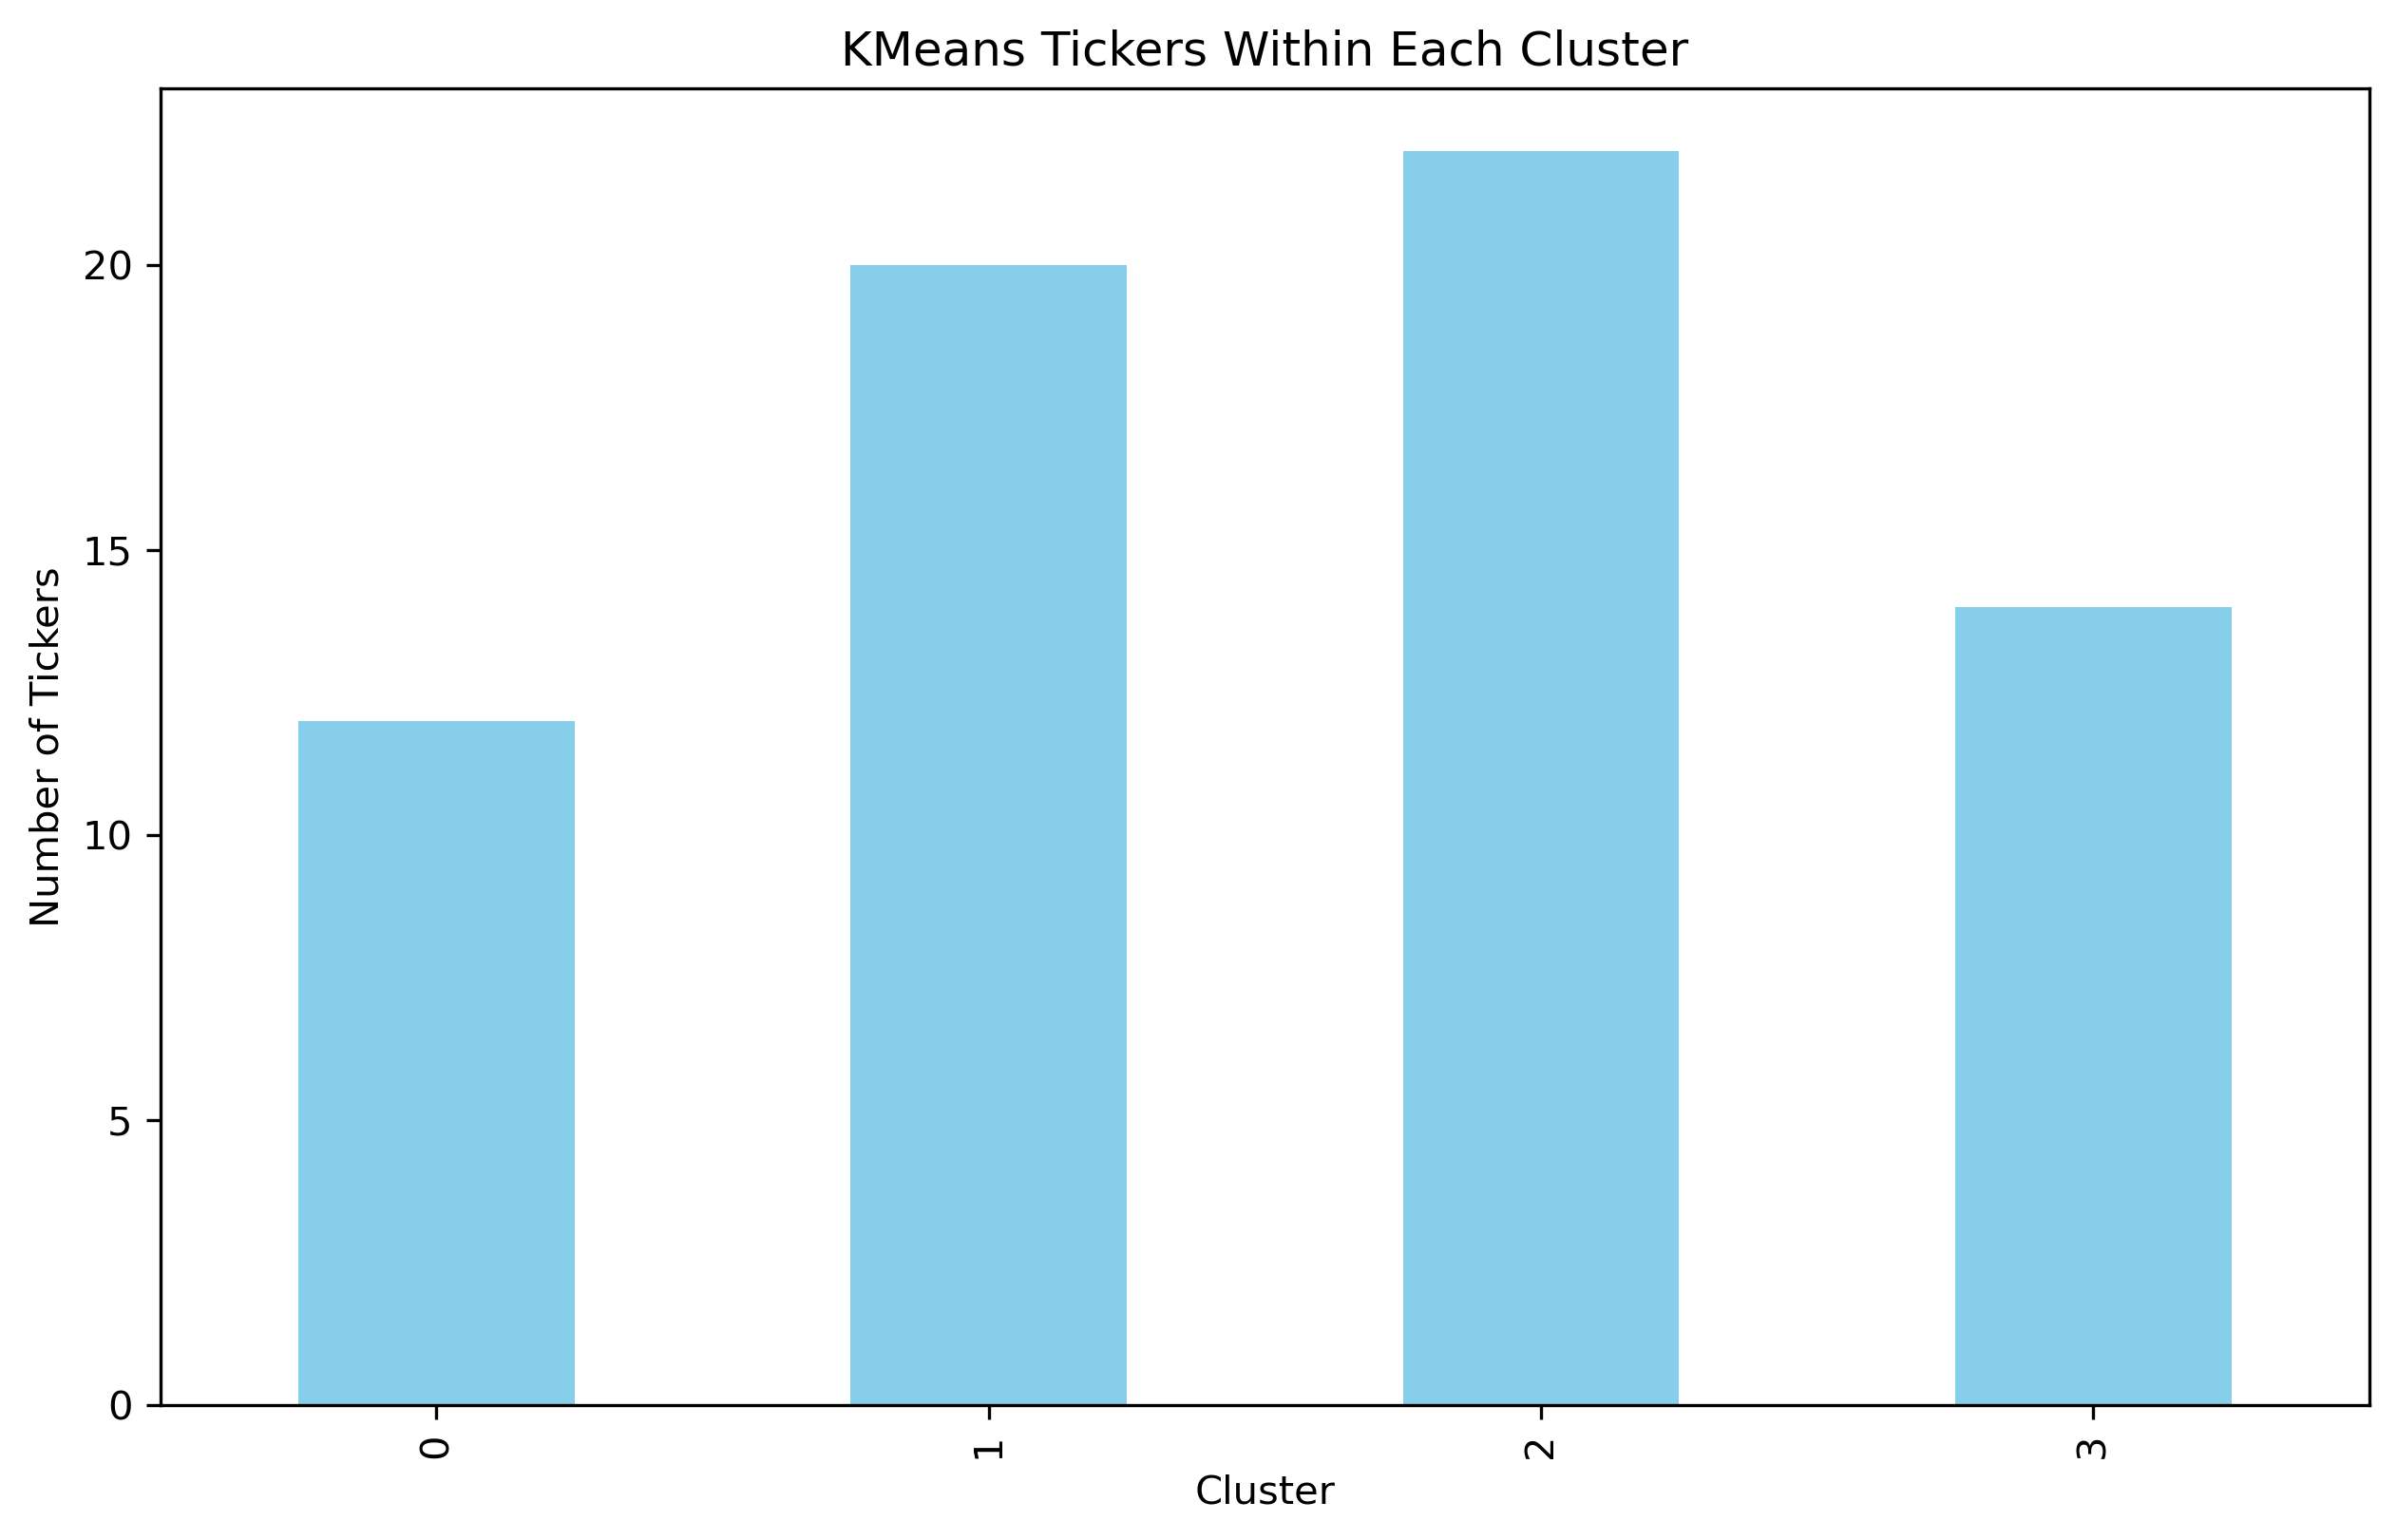

In [50]:
k_means = KMeans(n_clusters=4)
k_means.fit(X_reshaped)


labels = k_means.labels_


df_clusters = pd.DataFrame({'Ticker': X_reshaped.index, 'Cluster': labels})


df_clusters['Cluster'].value_counts().sort_index().plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.xlabel('Cluster')
plt.ylabel('Number of Tickers')
plt.title('KMeans Tickers Within Each Cluster')
plt.show()

In [51]:
clustered_series_km = pd.Series(index=X_reshaped.index, data=k_means.labels_.flatten())
clustered_series_km = clustered_series_km[clustered_series_km != -1]

### Identifying Tickers within K-Means cluster

In [52]:
#Total stocks in each cluster
clustered_series_km.value_counts()

2    22
1    20
3    14
0    12
Name: count, dtype: int64

In [53]:
len(clustered_series_km)

68

In [54]:
clusters_indices_km = {i: clustered_series_km[clustered_series_km == i].index for i in range(k_means.n_clusters)}
clusters_indices_km

{0: Index([1, 5, 6, 16, 20, 388, 939, 998, 1288, 1398, 3968, 3988], dtype='int64'),
 1: Index([  27,  291,  525,  669,  868,  902,  914,  916,  960, 1093, 1099, 1109,
        1211, 1928, 2007, 2313, 2319, 2333, 2380, 3900],
       dtype='int64'),
 2: Index([ 123,  168,  316,  386,  688,  700,  728,  762,  836,  857,  883,  941,
         992, 1038, 1088, 1299, 2318, 2328, 2388, 2601, 2628, 6030],
       dtype='int64'),
 3: Index([175, 241, 881, 981, 1171, 1177, 1919, 2020, 2331, 2382, 2688, 2899,
        3800, 3888],
       dtype='int64')}

## Hierachical Clustering (Agglomerative)
> We use for loop relying on `Silhoulette Coefficient` Score to identify the most optimal k no. of clusters for Agglomerative clustering

In [55]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

# Calulate linkage
Z = linkage(X_reshaped, method = "ward")

Z[0]

array([ 6.        , 58.        ,  0.12441033,  2.        ])

In [56]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

# Using Silhoulette Score to determine best k cluster
scores = []
for k in range(2, 10):
    hc = AgglomerativeClustering(n_clusters=k)
    hc.fit(X_reshaped)
    scores.append(silhouette_score(X_reshaped, hc.labels_))

best_k = np.argmax(scores) + 2  # +2 because range starts at 2
best_k

2

### Based on Silhouette Score the best no. of cluster = `2`

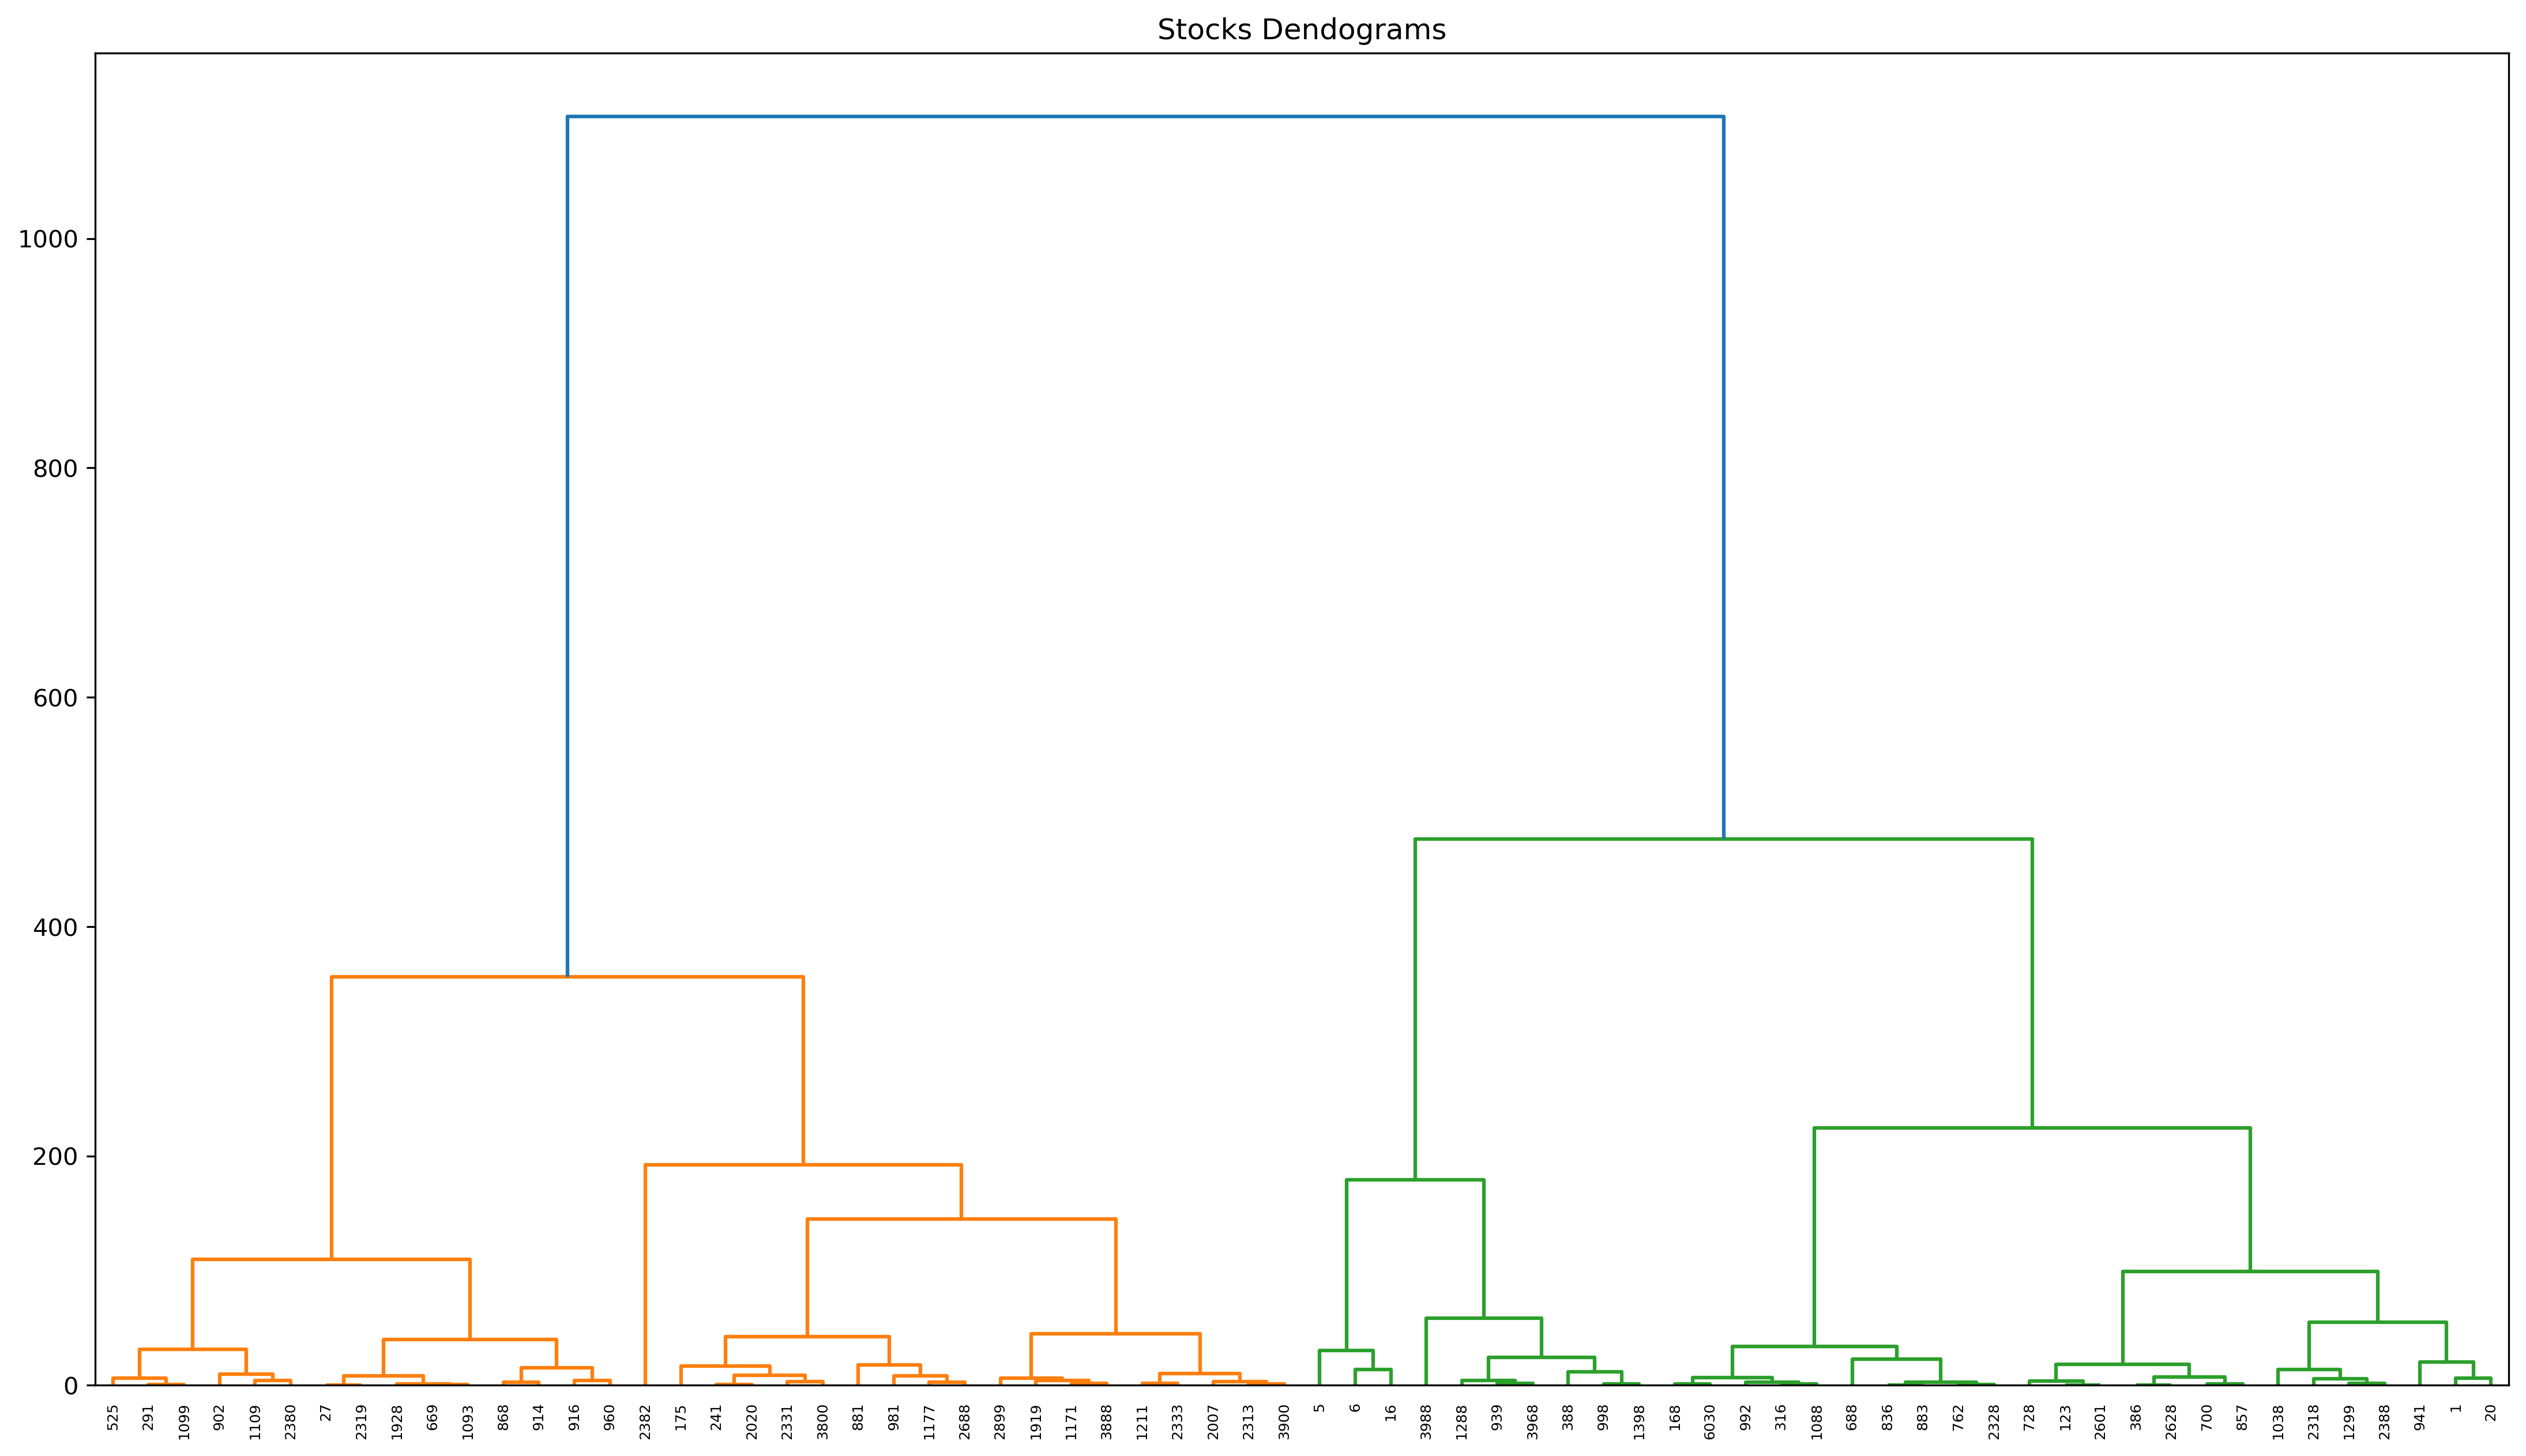

In [57]:
# Plot Dendogram

plt.figure(figsize=(18, 10)
          )
plt.title("Stocks Dendograms")

dendrogram(Z, labels = X_reshaped.index)

plt.show()

In [59]:
nclust = 2

hc = AgglomerativeClustering(n_clusters = nclust,
                             affinity = "euclidean",
                             linkage = "ward")

clust_labels1 = hc.fit_predict(X_reshaped)

In [60]:
# show number of stocks in each cluster

clustered_series_hc = pd.Series(index=X_reshaped.index, data=hc.labels_.flatten()
                            )
#Filter out any datapoint that are not assign to any cluster as "-1"
clustered_series_hc = clustered_series_hc[clustered_series_hc != -1]

In [61]:
clusters_indices_hc = {i: clustered_series_hc[clustered_series_hc == i].index for i in np.unique(hc.labels_)}
clusters_indices_hc

{0: Index([   1,    5,    6,   16,   20,  123,  168,  316,  386,  388,  688,  700,
         728,  762,  836,  857,  883,  939,  941,  992,  998, 1038, 1088, 1288,
        1299, 1398, 2318, 2328, 2388, 2601, 2628, 3968, 3988, 6030],
       dtype='int64'),
 1: Index([  27,  175,  241,  291,  525,  669,  868,  881,  902,  914,  916,  960,
         981, 1093, 1099, 1109, 1171, 1177, 1211, 1919, 1928, 2007, 2020, 2313,
        2319, 2331, 2333, 2380, 2382, 2688, 2899, 3800, 3888, 3900],
       dtype='int64')}

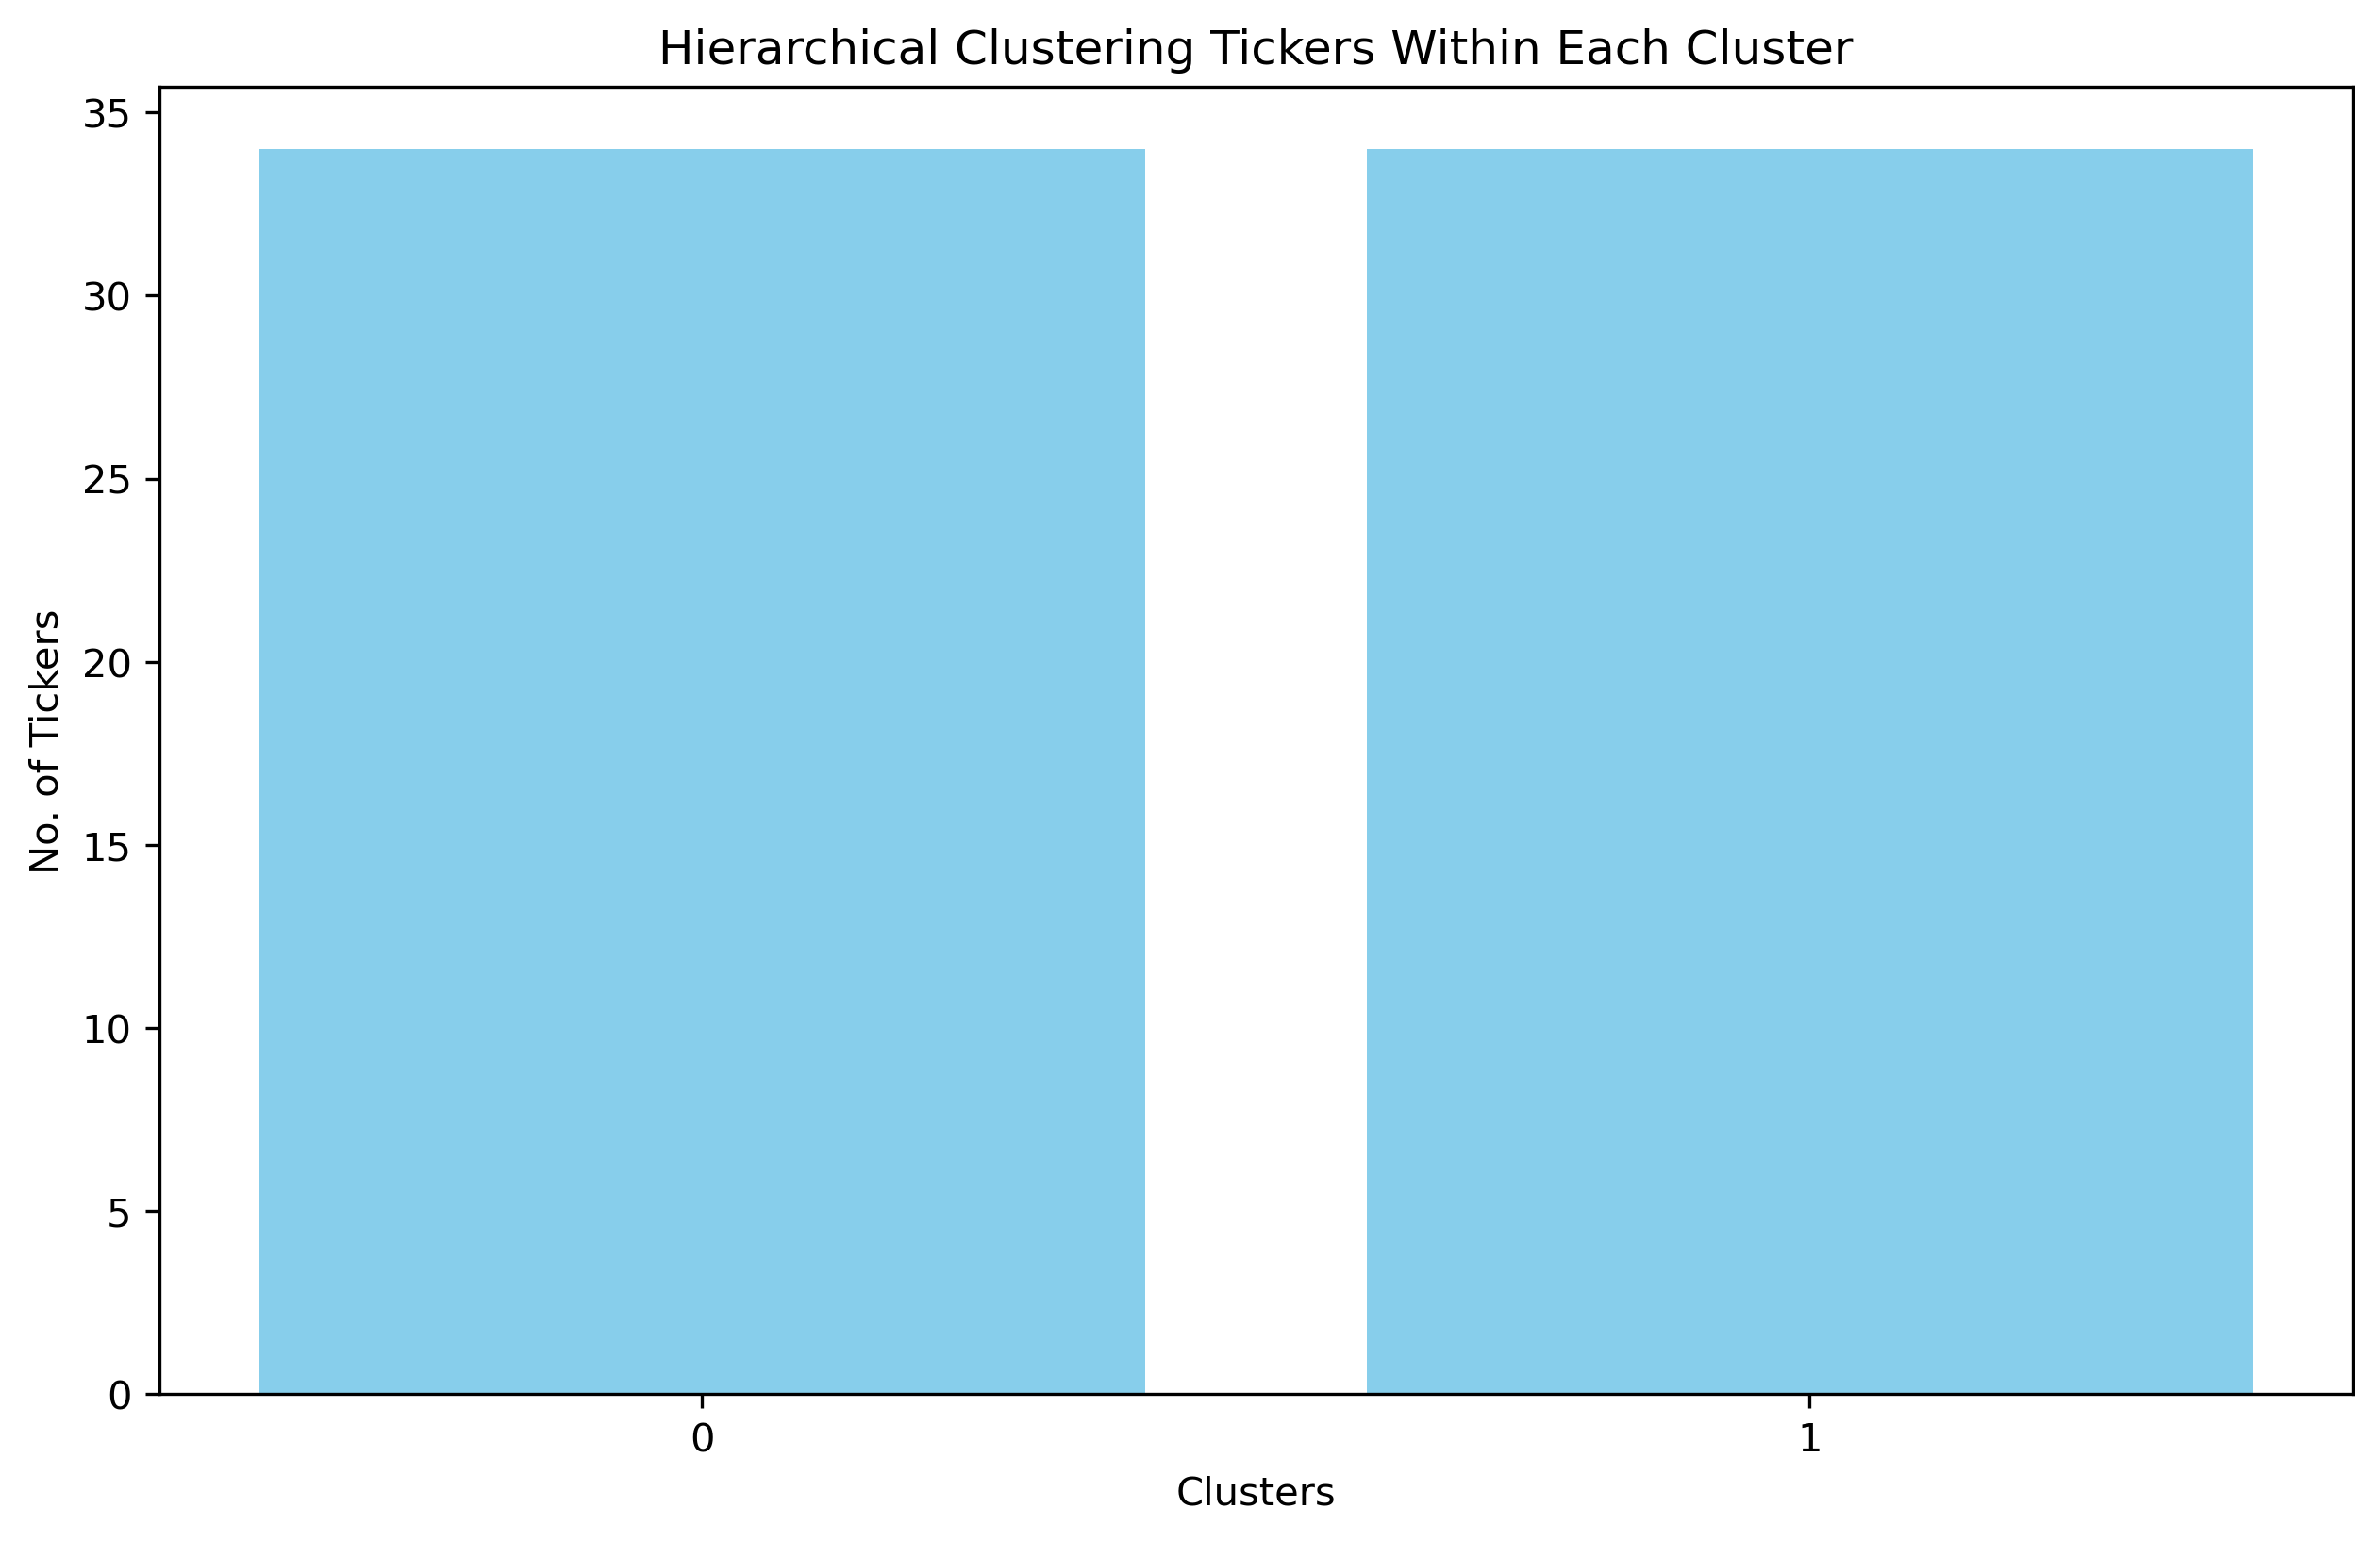

In [62]:
# Count the number of stocks in each cluster
cluster_counts = clustered_series_hc.value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(cluster_counts.index, cluster_counts.values, color='skyblue')

plt.xlabel('Clusters')
plt.ylabel('No. of Tickers')
plt.title('Hierarchical Clustering Tickers Within Each Cluster')

plt.xticks(np.arange(min(cluster_counts.index), max(cluster_counts.index)+1, 1), fontsize=10)

plt.show()

## Affinity Propagation Clustering

In [63]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, ward

ap = AffinityPropagation()

ap.fit(X_reshaped)

clust_labels2 = ap.predict(X_reshaped)

### AP Visualization

In [64]:
cluster_centers_indices = ap.cluster_centers_indices_
labels = ap.labels_

Estimated number of clusters: 7


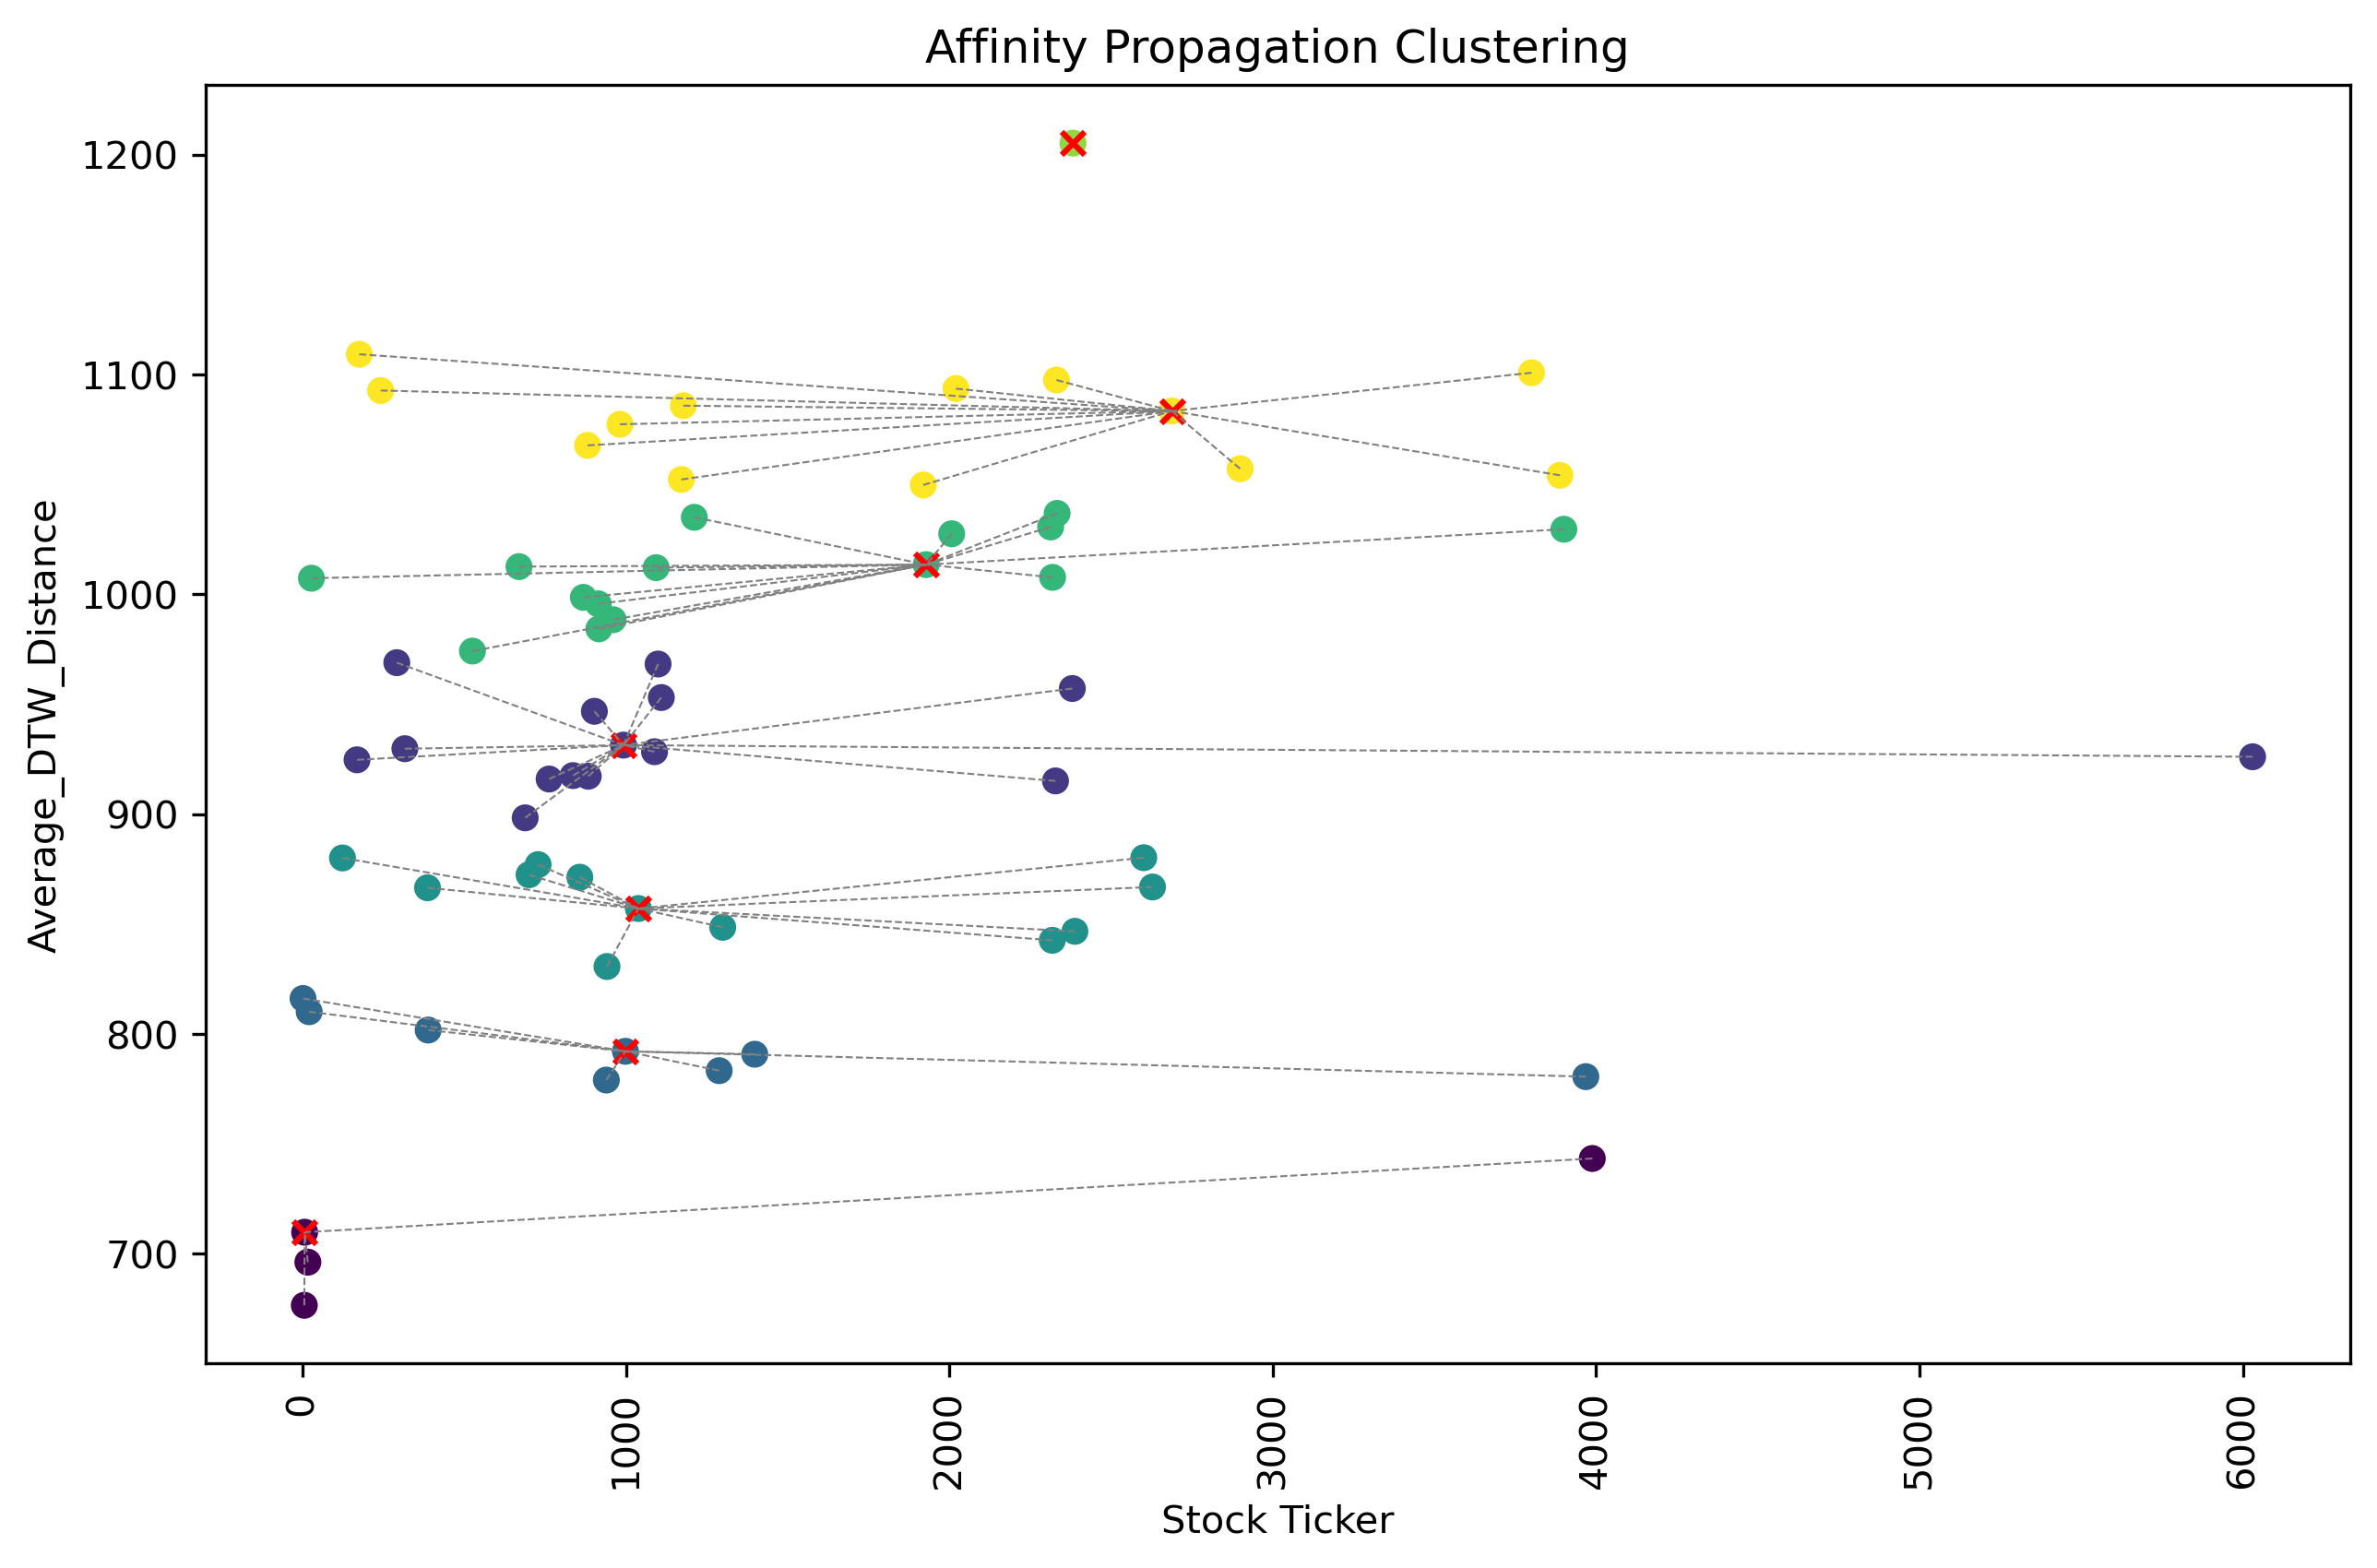

In [65]:
no_clusters = len(cluster_centers_indices)
print("Estimated number of clusters: %d" % no_clusters)

# Get the unique labels
unique_labels = np.unique(labels)

# Create a scatter plot of the data points
plt.figure(figsize=(10, 6))
plt.scatter(X_reshaped.index, X_reshaped['Average_DTW_Distance'], c=clust_labels2)

# Mark the cluster centers
plt.scatter(X_reshaped.index[cluster_centers_indices], X_reshaped.iloc[cluster_centers_indices], c='red', marker='x')

# Draw lines between the cluster centers and their data points
for cluster_center in cluster_centers_indices:
    cluster_label = clust_labels2[cluster_center]
    cluster_points = np.where(clust_labels2 == cluster_label)[0]
    for point in cluster_points:
        plt.plot([X_reshaped.index[point], X_reshaped.index[cluster_center]],
                 [X_reshaped.iloc[point], X_reshaped.iloc[cluster_center]],
                 c='gray', linestyle='--', linewidth=0.5)

plt.title('Affinity Propagation Clustering')
plt.xlabel('Stock Ticker')
plt.ylabel('Average_DTW_Distance')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

In [66]:
# show number of stocks in each cluster
clustered_series_ap = pd.Series(index=X_reshaped.index, data=ap.labels_.flatten()
                               )

In [67]:
#Filter out any datapoint that are not assign to any cluster as "-1"
clustered_series_ap = clustered_series_ap[clustered_series_ap != -1]

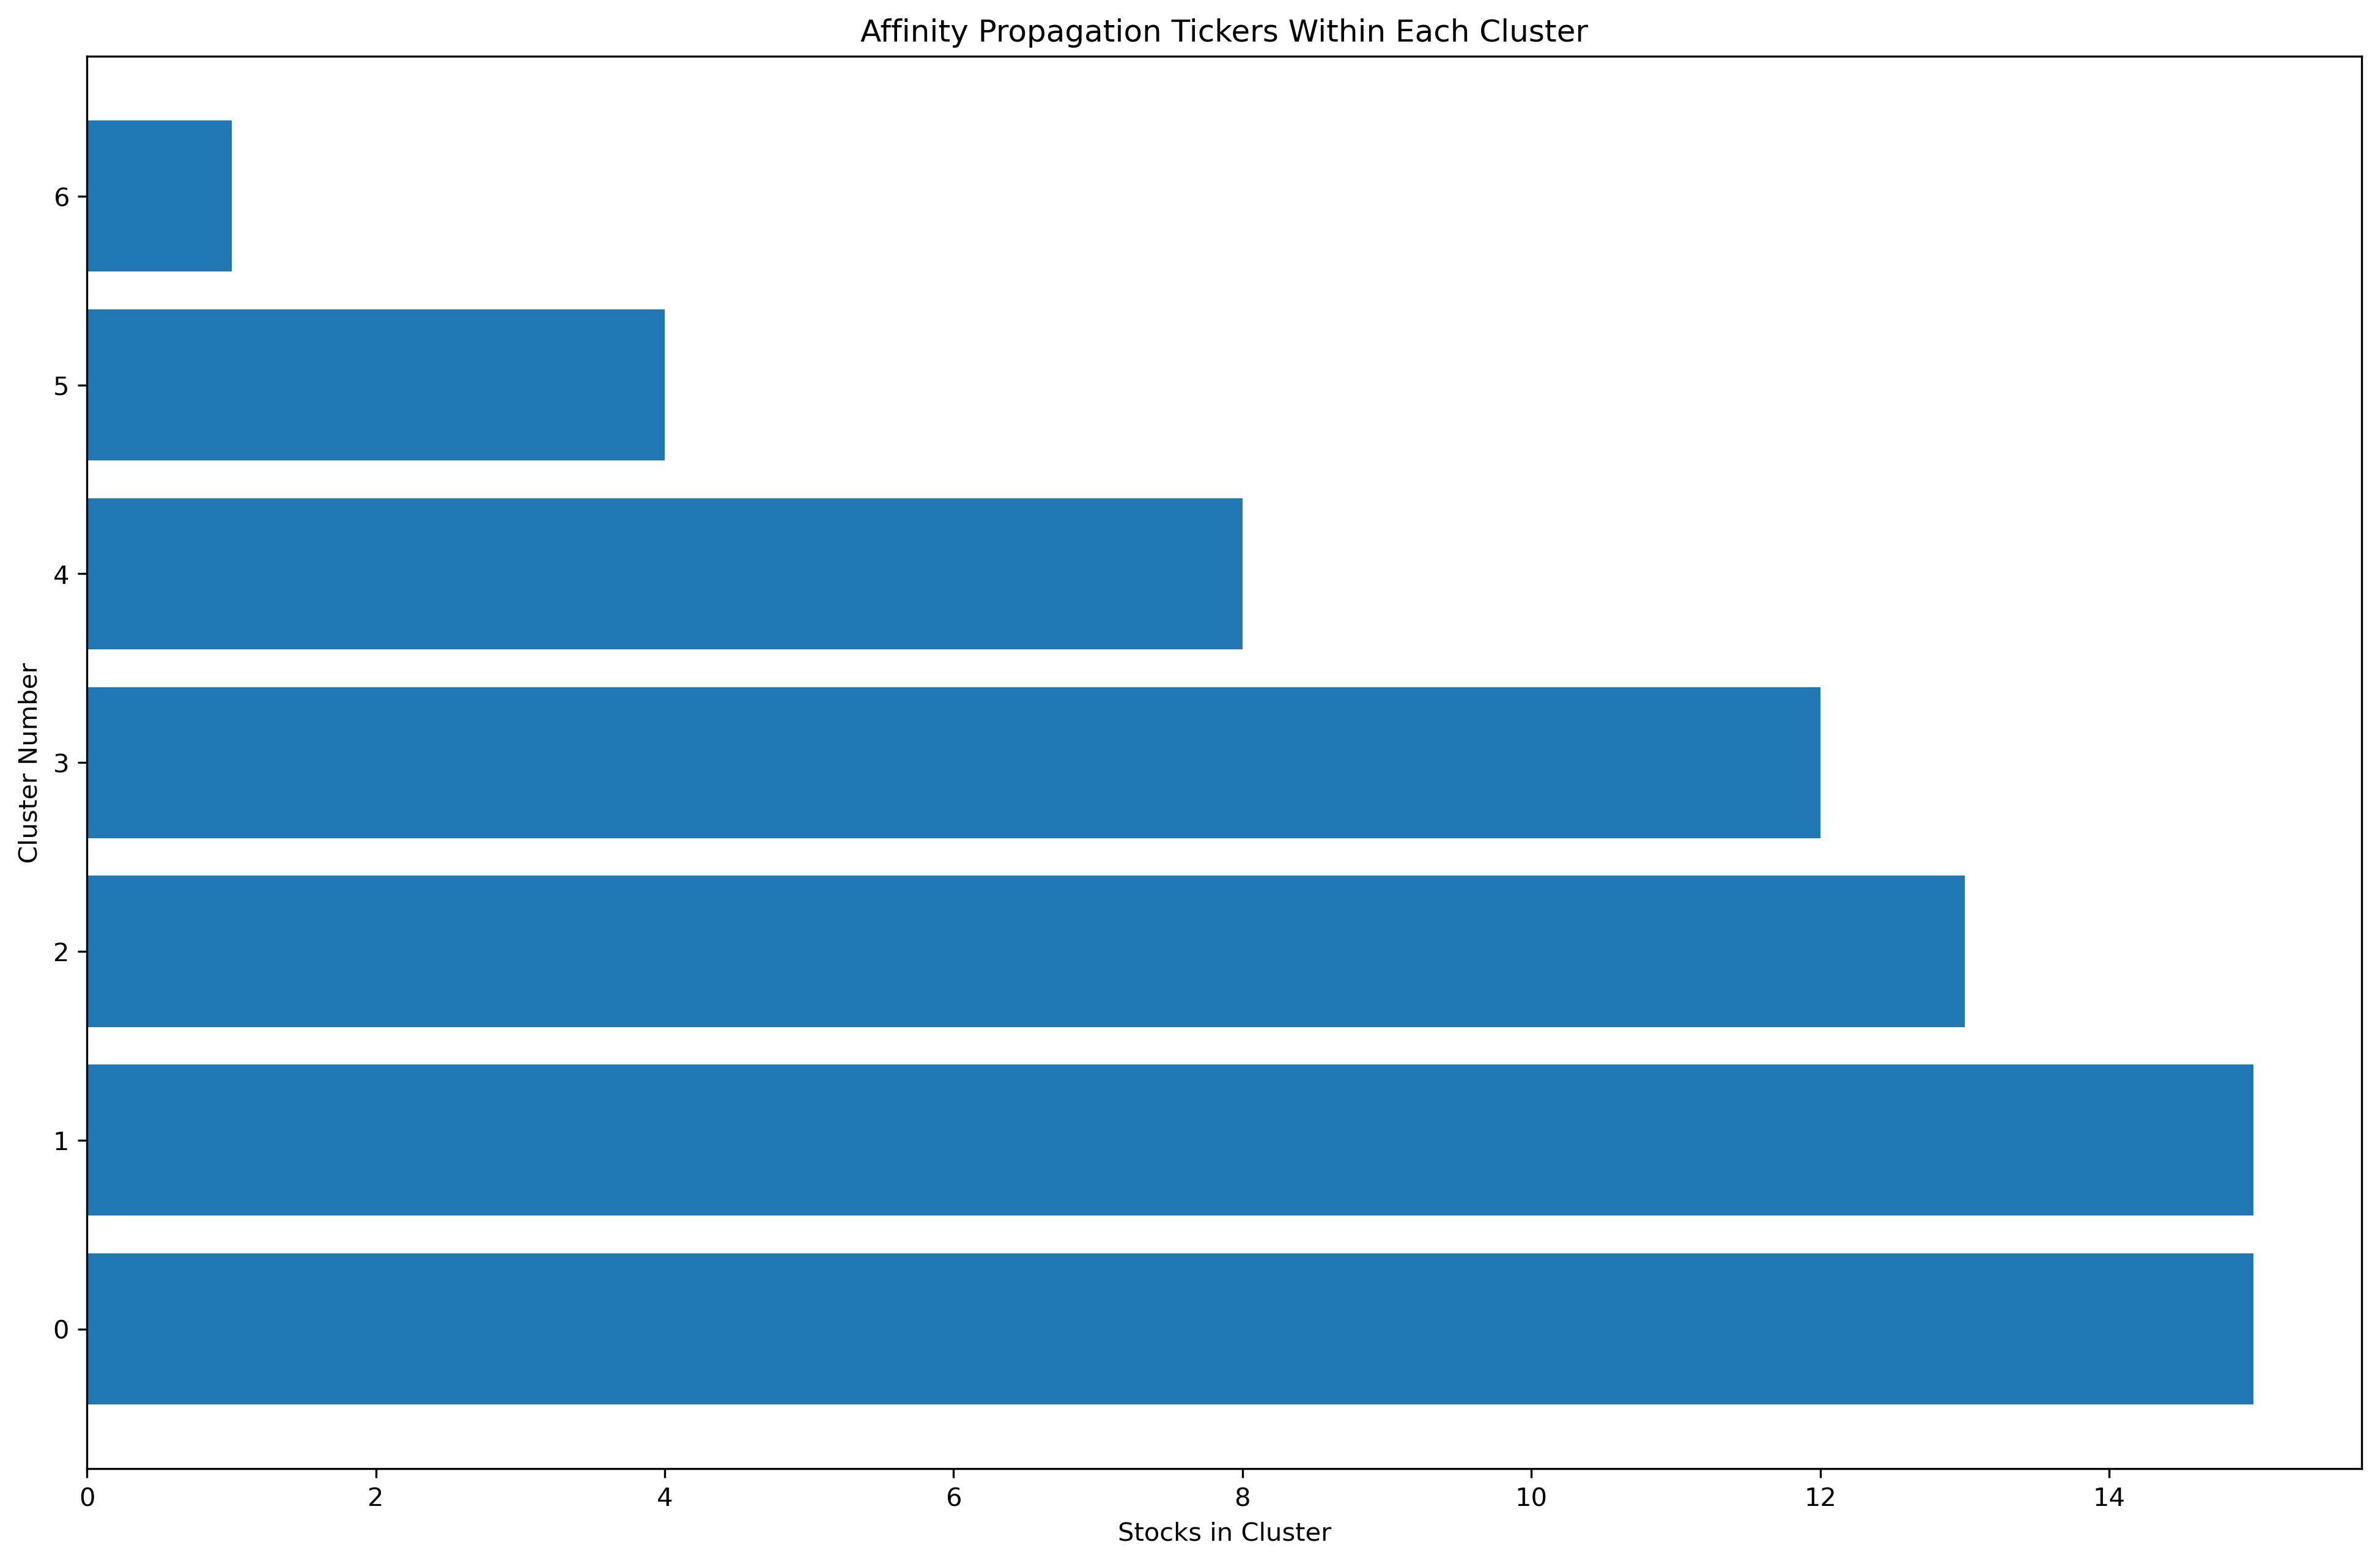

In [68]:
plt.figure(figsize=(16,10)
          )

plt.barh(
    range(len(clustered_series_ap.value_counts()
             )
         ), # cluster labels, y axis
    clustered_series_ap.value_counts()
)

plt.title("Affinity Propagation Tickers Within Each Cluster")
plt.xlabel("Stocks in Cluster")
plt.ylabel("Cluster Number")

plt.show()

### Identify Tickers Within Affinity Propagation Cluster

In [69]:
clusters_indices_ap = {i: clustered_series_ap[clustered_series_ap == i].index for i in np.unique(ap.labels_)}
clusters_indices_ap

{0: Index([5, 6, 16, 3988], dtype='int64'),
 1: Index([168, 291, 316, 688, 762, 836, 883, 902, 992, 1088, 1099, 1109, 2328,
        2380, 6030],
       dtype='int64'),
 2: Index([1, 20, 388, 939, 998, 1288, 1398, 3968], dtype='int64'),
 3: Index([123, 386, 700, 728, 857, 941, 1038, 1299, 2318, 2388, 2601, 2628], dtype='int64'),
 4: Index([  27,  525,  669,  868,  914,  916,  960, 1093, 1211, 1928, 2007, 2313,
        2319, 2333, 3900],
       dtype='int64'),
 5: Index([2382], dtype='int64'),
 6: Index([175, 241, 881, 981, 1171, 1177, 1919, 2020, 2331, 2688, 2899, 3800,
        3888],
       dtype='int64')}

### Clustering Algorithm Evaluation Metrics
#### Comparing against K-Means vs Agglomerative Hierarchical Clustering vs Affinity Propagation methods. To measure model performance we use Intrinsic Evaluation Metric where there are no ground truth labels available.

> `Silhouette Coefficient` Score measures how close each sample in one cluster is to the samples in the neighboring clusters..The best value is 1 and the worst value is -1. Values near 0 indicate sample close to cluster decision boundary while negative value indicate wrong clustering.

> `Calinski-Harabasz Index` Score is defined as an Internal Clustering Validation ratio of the sum of between-cluster dispersion and of within-cluster dispersion the higher the score the better the performance

> `Davies Bouldin Index` Score defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score. The minimum score is zero, with lower values indicating better clustering.

In [70]:
from sklearn import metrics

print("\n----------Silhoulette Score----------\n")

print("K-Means :", metrics.silhouette_score(X_reshaped, kmeans.labels_)
     )

print("Agglomerative Hierarchical :", metrics.silhouette_score(X_reshaped, hc.fit_predict(X_reshaped),
                                     metric='euclidean')
     )

print("Affinity Propagation :", metrics.silhouette_score(X_reshaped, ap.labels_,
                                     metric='euclidean')
     )

print("\n----------Calinski-Harabasz Index----------\n")


print("K-Means :", metrics.calinski_harabasz_score(X_reshaped, kmeans.labels_)
     )

print("Agglomerative Hierarchical :", metrics.calinski_harabasz_score(X_reshaped, hc.fit_predict(X_reshaped))
     )

print("Affinity Propagation :", metrics.calinski_harabasz_score(X_reshaped, ap.labels_)
     )

print("\n----------Davies-Bouldin Index----------\n")

print("K-Means :", metrics.davies_bouldin_score(X_reshaped, kmeans.labels_)
     )

print("Agglomerative Hierarchical :", metrics.davies_bouldin_score(X_reshaped, hc.fit_predict(X_reshaped))
     )

print("Affinity Propagation :", metrics.davies_bouldin_score(X_reshaped, ap.labels_)
     )



----------Silhoulette Score----------

K-Means : 0.5844500087935521
Agglomerative Hierarchical : 0.5917165679497547
Affinity Propagation : 0.5848175076184303

----------Calinski-Harabasz Index----------

K-Means : 1366.1156610109422
Agglomerative Hierarchical : 150.93934799095928
Affinity Propagation : 378.2074401165306

----------Davies-Bouldin Index----------

K-Means : 0.35311695678482397
Agglomerative Hierarchical : 0.5333106401926954
Affinity Propagation : 0.38443711213277304


#### K Means algorithm performs well in Calinski Harabasz and Davies Bouldin index but performs worse in Silhouette Score than Agglomerative Clustering and Affinity Propagation, albeit all three models have very similar score.Therefore, we choose to go with K-Means that showed consistently well performance across all three performance metrics. K-Means cluster stocks will be used to perform DTW operation to identify optimal pairs.

In [71]:
CLUSTER_SIZE_LIMIT = 9999

counts = clustered_series_km.value_counts()

ticker_count_reduced = counts[(counts>1) & (counts <= CLUSTER_SIZE_LIMIT)] #filter for clusters with >1 stock and below max limit

print ("Clusters formed: %d" % len(ticker_count_reduced)
      )
print ("Pairs to evaluate: %d" % np.divide((ticker_count_reduced*(ticker_count_reduced-1)).sum(), 2)
      )


Clusters formed: 4
Pairs to evaluate: 578


In [72]:
# Cluster no. and their corresponding no. of stocks within respective cluster
counts

2    22
1    20
3    14
0    12
Name: count, dtype: int64

In [73]:
sum(counts)

68

In [74]:
 # Cluster no. with >1 stock in each respective cluster
ticker_count_reduced

2    22
1    20
3    14
0    12
Name: count, dtype: int64

# Dynamic Time Warping on Clustered Dataset

In [75]:
from dtwParallel import dtw_functions as dtw
from scipy.spatial import distance as distance
import warnings
warnings.filterwarnings('ignore')

def calculate_dtw_postclust(df):
    # Create an empty DataFrame to store the results
    results2 = pd.DataFrame(columns=['Ticker_1', 'Ticker_2', 'DTW_Distance'])

    # Iterate over each cluster
    for cluster in clusters_indices_km:
      # Get the list of tickers in the current cluster
      tickers = clusters_indices_km[cluster]

      # Iterate over each ticker in the cluster
      for i in range(len(tickers)):
          ticker_1 = tickers[i]
          x = np.asarray([dataset[ticker_1].values])

          # Compare the current ticker with all other tickers in the cluster
          for j in range(i + 1, len(tickers)):
              ticker_2 = tickers[j]
              y = np.asarray([dataset[ticker_2].values])

              # Calculate the DTW distance
              dtw_distance = dtw.dtw(x, y,
                                    type_dtw="d",
                                    constrained_path_search="sakoe_chiba",
                                    local_dissimilarity=distance.cityblock,
                                    check_errors=True,
                                    MTS=True)

              # Add the result to the DataFrame
              new_row = pd.DataFrame({
                  'Ticker_1': [ticker_1],
                  'Ticker_2': [ticker_2],
                  'DTW_Distance': [dtw_distance]
              })

              results2 = pd.concat([results2, new_row], ignore_index=True)

    # Return the results
    return results2

In [76]:
km_clust = pd.DataFrame.from_dict(clusters_indices_km, orient='index')
km_clust

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,1,5,6,16,20,388,939,998,1288,1398,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27,291,525,669,868,902,914,916,960,1093,...,1211.0,1928.0,2007.0,2313.0,2319.0,2333.0,2380.0,3900.0,NaN,NaN
2,123,168,316,386,688,700,728,762,836,857,...,992.0,1038.0,1088.0,1299.0,2318.0,2328.0,2388.0,2601.0,2628.0,6030.0
3,175,241,881,981,1171,1177,1919,2020,2331,2382,...,3800.0,3888.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
results2 = calculate_dtw_postclust(clusters_indices_km)

### Dataframe `results2` produce the DTW distance and all the possible 'n choose 2' combinations from the clustered dataset.

In [78]:
# Sort the DataFrame by 'DTW_Distance' in ascending order
sorted_results = results2.sort_values('DTW_Distance')

# Convert the sorted DataFrame to a list of lists
sorted_pairs = sorted_results[['Ticker_1', 'Ticker_2', 'DTW_Distance']].values.tolist()

# Create a new DataFrame from the sorted pairs
sorted_df = pd.DataFrame(sorted_pairs, columns=['Ticker_1', 'Ticker_2', 'DTW_Distance'])

sorted_df.head(10)

,Ticker_1,Ticker_2,DTW_Distance
0,1288,3988,335.33
1,998,1398,453.44
2,939,1398,923.47
3,939,998,1024.79
4,902,916,1077.47
5,525,2380,1198.53
6,857,992,1216.54
7,386,857,1291.75
8,2899,3800,1305.89
9,1919,2899,1339.13


# Inspect Dataset Ensuring No Duplicates

In [79]:
# Check for duplicate rows
duplicates = sorted_df.duplicated()
print(f"Number of duplicated dataframe rows: {duplicates.sum()}")

# Check for duplicates based on specific columns
duplicates2 = sorted_df.duplicated(subset=['Ticker_1', 'Ticker_2'])
print(f"Number of duplicated Ticker rows: {duplicates2.sum()}")


Number of duplicated dataframe rows: 0
Number of duplicated Ticker rows: 0


### Save `results2` dataframe into csv

In [80]:
# Save dataframe into csv file
sorted_df.to_csv('V2_dtw_matrix-HK100_post_cluster.csv')